In [1]:
import sys
sys.path.insert(0, '../deep_feat') # to reach DeepLKBatch
import DeepLKBatch as dlk
import sift_ransac_homography as srh

import torch
import torch.nn as nn
from torchvision import models, transforms
import io
import requests
from PIL import Image
from torch.autograd import Variable
from torch.nn.functional import grid_sample
from sys import argv
import argparse
import time
from math import cos, sin, pi, sqrt, ceil
import random
import sys
import autograd.numpy as np
from autograd import grad, jacobian
from functools import reduce
from pdb import set_trace as st
import argparse
import glob
import matplotlib.pyplot as plt
import scipy.io as sio

In [2]:
def optimize(I, P, T, V, tol, coeff_mult):
	'''
	Args:
		I: Image sequence, 4D numpy array, num_frame x C x H x W
		P: Warp parameter sequence, 3D numpy array, num_frame x 8 x 1
		T: Numpy vector containing indices from I which are templates
		V: Numpy array of numpy arrays, indicating the visibility neighborhood for each template

	Returns:
		P_opt: Bundle adjusted warp parameter sequence, 3D numpy array, num_frame x 8 x 1
	'''

	num_frame = I.shape[0]

	def size_fn(a):
		return a.size

	size_fn_vec = np.vectorize(size_fn)

	V_sz = size_fn_vec(V)
	sigma = V_sz.sum()

	_, img_c, img_h, img_w = I.shape

	I_gradx = np.gradient(I, axis=3)
	I_grady = np.gradient(I, axis=2)

	dP = np.zeros([num_frame - 1, 8, 1])
	crit = 0

	itn = 1

	coeff = 1

	while ((crit > tol) or (itn == 1)) and (itn < 200):
		P_fk = compute_Pfk(P, T, V, V_sz)

		r_ba = compute_ri(I, T, V, P_fk, V_sz)

		J_ba = compute_Ji(I_gradx, I_grady, P, T, V, P_fk, V_sz)

		J_ba_trans = J_ba.swapaxes(2,3)

		J_ba_trans_J_ba = np.matmul(J_ba_trans, J_ba) 

		Hess = np.sum(J_ba_trans_J_ba, axis=1)

		invHess = np.linalg.inv(Hess)

		J_ba_trans_r_ba = np.matmul(J_ba_trans, r_ba)

		J_ba_trans_r_ba_sum = np.sum(J_ba_trans_r_ba, axis=1)

		dP = np.matmul(invHess, J_ba_trans_r_ba_sum)

		P = P + dP * coeff

		dp_norm = np.linalg.norm(dP, ord=2, axis=1)
		crit = np.amax(dp_norm)

		if (itn % 10 == 0):
			coeff = coeff * coeff_mult

		print('itn:  {:d}'.format(itn))
		print('crit: {:.5f}'.format(crit))

		# print('coeff: {:.2f}'.format(coeff))
		# print(P)
		# print(dP)

		itn = itn + 1

	return P

In [3]:




def optimize_wmap(I, P, T, V, P_init, M_feat, T_feat, tol, max_itr, lam1, lam2):
	'''
	Args:
		I: Image sequence, 4D numpy array, num_frame x C x H x W
		P: Warp parameter sequence, 3D numpy array, num_frame x 8 x 1
		M: Map image sequence, 4D numpy array, k x C x H x W
		T: Numpy vector containing indices from I which are templates, length k
		V: Numpy array of numpy arrays, indicating the visibility neighborhood for each template
		P_init: Absolute warp parameters relating map to first frame, 1 x 8 x 1
		M_feat: Sequence of deep feature map images, 4D numpy array, k x Cf x Hf x Wf
		T_feat: Template images from I deep feature extractions, 4D numpy array, k x Cf x Hf x Wf
		tol: tolerance of iteration criteria
		max_itr: maximum number of optimization iterations
		lam1: weighting for sequence motion parameters
		lam2: weight for map params
	
	Returns:
		P_opt: Bundle adjusted warp parameter sequence, 3D numpy array, num_frame x 8 x 1
	'''

	num_frames = I.shape[0]

	def size_fn(a):
		return a.size

	size_fn_vec = np.vectorize(size_fn)

	V_sz = size_fn_vec(V)
	sigma = V_sz.sum()

	I_gradx = np.gradient(I, axis=3)
	I_grady = np.gradient(I, axis=2)

	Mf_gradx = np.gradient(M_feat, axis=3)
	Mf_grady = np.gradient(M_feat, axis=2)

	P_mk0 = compute_Pmk(P_init, P, T)

	dP = np.zeros([num_frames - 1, 8, 1])
	crit = 0

	itn = 1

	while ((crit > tol) or (itn == 1)) and (itn < max_itr):
		P_fk = compute_Pfk(P, T, V, V_sz)
		P_mk = compute_Pmk(P_init, P, T)

		# warping: H_P * inv(H_P0) <- by rules of homography

		# convert sampling params to sampling hmg:
		H_mk_samp = p_to_H(P_mk)
		H_mk0_samp = p_to_H(P_mk0)

		# invert sampling params to get coord params:
		H_mk = np.linalg.inv(H_mk_samp)
		H_mk0 = np.linalg.inv(H_mk0_samp)

		# compute relative hmg:
		H_mk_rel = np.matmul(H_mk, np.linalg.inv(H_mk0))

		# invert back to sampling hmg:
		H_mk_rel_samp = np.linalg.inv(H_mk_rel)

		# convert sampling hmg back to sampling params:
		P_mk_rel_samp = H_to_p(H_mk_rel_samp)

		ri = compute_ri(I, T, V, P_fk, V_sz)

		rm_rsh = compute_rm(M_feat, T_feat, P_mk_rel_samp)
		rm = np.tile(rm_rsh, (num_frames - 1, 1, 1, 1))

		Ji = compute_Ji(I_gradx, I_grady, P, T, V, P_fk, V_sz)
		Jm = compute_Jm(Mf_gradx, Mf_grady, P_init, P, T, P_mk_rel_samp, P_mk0)

		Ji_trans = Ji.swapaxes(2,3)
		Ji_trans_Ji = lam1 * np.matmul(Ji_trans, Ji)

		Jm_trans = Jm.swapaxes(2,3)
		Jm_trans_Jm = lam2 * np.matmul(Jm_trans, Jm) 

		Hm = np.sum(Jm_trans_Jm, axis=1)
		Hi = np.sum(Ji_trans_Ji, axis=1)

		invH = np.linalg.inv(Hm + Hi)

		Jm_trans_rm = lam2 * np.matmul(Jm_trans, rm)
		Ji_trans_ri = lam1 * np.matmul(Ji_trans, ri)

		Jm_trans_rm_sum = np.sum(Jm_trans_rm, axis=1)
		Ji_trans_ri_sum = np.sum(Ji_trans_ri, axis=1)

		dP = np.matmul(invH, Jm_trans_rm_sum + Ji_trans_ri_sum)

		dP[:, 6:8, :] = 0

		P = P + dP

		dp_norm = np.linalg.norm(dP, ord=2, axis=1)
		crit = np.amax(dp_norm)

		print('itn:  {:d}'.format(itn))
		print('crit: {:.5f}'.format(crit))

		itn = itn + 1

	return P

In [4]:
def compute_rm(M_feat, T_feat, P_mk_rel):
	'''
	Args:
		M_feat: Sequence of deep feature map images, 4D numpy array, k x Cf x Hf x Wf
		T_feat: Template images from I deep feature extractions, 4D numpy array, k x Cf x Hf x Wf
		P_mk_rel: Numpy array, warp parameters for each of the map images, k x 8 x 1

	Returns:
		rm: Numpy array, residuals of map images with templates, num_frame - 1 (duplicated dim.) x k x (Cf x Hf x Wf) x 1
	'''

	k, map_c, map_h, map_w = M_feat.shape

	P_mk_rel_tens = torch.from_numpy(P_mk_rel).float()
	M_feat_tens = torch.from_numpy(M_feat).float()

	M_feat_warp_tens, M_feat_mask_tens = dlk.warp_hmg(M_feat_tens, P_mk_rel_tens)

	M_feat_warp = M_feat_warp_tens.numpy()
	M_feat_mask = M_feat_mask_tens.numpy()

	M_feat_mask_tile = np.tile(np.expand_dims(M_feat_mask, 1), (1, map_c, 1, 1))

	T_feat_mask = np.multiply(T_feat, M_feat_mask_tile)

	r_m = T_feat_mask - M_feat_warp

	r_m_rsh = r_m.reshape((k, map_c * map_h * map_w, 1))

	return r_m_rsh

In [5]:
def compute_ri(I, T, V, P_fk, V_sz):
	'''
	Args:
		I: Image sequence, 4D numpy array, num_frame x C x H x W
		T: Numpy vector containing indices from I which are templates
		V: Numpy array of numpy arrays, indicating the visibility neighborhood for each template
		P_fk: Numpy array, warps images I to respective templates T, sigma x 8 x 1
		V_sz: Numpy array, 1D, indicating number of images in each visibility neighborhood

	Returns:
		r_ba: Numpy array, residuals of images with templates, num_frame - 1 x sigma x (C x H x W) x 1
	'''

	sigma = V_sz.sum()

	num_frame, img_c, img_h, img_w = I.shape

	T_f = np.repeat(I[T, :, :, :], V_sz, axis=0)

	I_f = np.zeros((sigma, img_c, img_h, img_w))

	I_f_ind = 0
	for i in range(len(V)):
		for f in V[i]:
			I_f[I_f_ind, :, :, :] = I[f, :, :, :]
			I_f_ind = I_f_ind + 1

	P_kf_tens = torch.from_numpy(P_fk).float()
	I_f_tens = torch.from_numpy(I_f).float()

	I_f_warp_tens, I_f_mask_tens = dlk.warp_hmg(I_f_tens, P_kf_tens)

	I_f_warp = I_f_warp_tens.numpy()
	I_f_mask = I_f_mask_tens.numpy()

	I_f_mask = np.tile(np.expand_dims(I_f_mask, 1), (1, img_c, 1, 1))

	T_f_mask = np.multiply(T_f, I_f_mask)

	r_ba =  T_f_mask - I_f_warp

	r_ba = r_ba.reshape((sigma, img_c * img_h * img_w, 1))

	r_ba = np.tile(r_ba, (num_frame - 1, 1, 1, 1))

	return r_ba

In [6]:
def compute_Jm(Mf_gradx, Mf_grady, P_init, P, T, P_mk_rel, P_mk0):
	'''
	Args:
		Mf_gradx: Map image gradients in x, numpy array, k x Cf x Hf x Wf
		Mf_grady: Map image gradients in y, numpy array, k x Cf x Hf x Wf
		P_init: Absolute warp parameters relating map to first frame, 1 x 8 x 1
		P: Warp parameter sequence, 3D numpy array, num_frame x 8 x 1
		T: Numpy vector containing indices from I which are templates, length k
		P_mk_rel: Numpy array, warp parameters used on each of the map templates, k x 8 x 1
		P_mk0: Numpy array, warp parameters from the map to each map template, k x 8 x 1	

	Returns:
		Jm: Numpy array, dM/dW * dW/dPmk * dPmk/dPF, num_frame - 1 x k x (Cf x Hf x Wf) x 8
	'''

	k_num = T.shape[0]
	num_frames = P.shape[0] + 1

	gradMf_warpjac = compute_gradI_warpjac(Mf_gradx, Mf_grady, P_mk_rel)
	gradMf_warpjac = np.tile(gradMf_warpjac, (num_frames - 1, 1, 1, 1))

	gradPmk_PF = np.zeros((num_frames - 1, k_num, 8, 8))

	for F in range(num_frames - 1):
		k_ind = 0
		for k in T:
			if (F < k):
				H_init = p_to_H(P_init)
				H_1k = p_to_H(P[0 : k, :, :])
				H_mk = np.concatenate((
					H_init,
					H_1k), axis=0)

				H_F_ind = F + 1

				def Pmk(P_F): # needs to calculate the derivative of P_F w.r.t. the actual image warp used on the given map template, since we are extracting the map template, and not resampling it every time

					H_F = p_to_H(P_F)

					H_mk_samp_temp = np.concatenate((
						H_mk[0 : H_F_ind, :, :],
						H_F,
						H_mk[H_F_ind + 1:, :, :]
					), axis=0)

					# invert to go from sampling parameters to coordinate parameters
					H_mk_temp = np.linalg.inv(H_mk_samp_temp)

					# intialize the map->map-template warp as coord hmg
					H_mk_coord = np.eye(3)

					for i in range(H_mk_temp.shape[0]):
						H_mk_coord = np.dot(H_mk_temp[i, :, :], H_mk_coord)

					# compute the map-template -> map-template warp
					H_mk0_samp = p_to_H(P_mk0[k_ind, :, :])
					H_mk0_coord = np.linalg.inv(H_mk0_samp)

					H_warp_coord = H_mk_coord @ np.linalg.inv(H_mk0_coord)

					# invert back to sampling params
					H_warp_samp = np.linalg.inv(H_warp_coord)

					P_mk = H_to_p(H_warp_samp)
					P_mk = P_mk.squeeze(0)

					return P_mk

				grad_P_mk = jacobian(Pmk)

				P_F = H_to_p(H_mk[H_F_ind, :, :])
				P_F = P_F.squeeze(0)

				gradPmk_PF[F, k_ind, :, :] = \
					grad_P_mk(P_F).squeeze(axis=1).squeeze(axis=2)

			else:
				gradPmk_PF[F, k_ind, :, :] = np.zeros((8,8))

			k_ind = k_ind + 1

	J_m = np.matmul(gradMf_warpjac, gradPmk_PF)

	return J_m

In [7]:
def compute_Ji(I_gradx, I_grady, P, T, V, P_fk, V_sz):
	'''
	Args:
		I_gradx: x-gradient of image sequence, 4D numpy array, num_frame x C x H x W
		I_grady: y-gradient of image sequence, 4D numpy array, num_frame X C x H x W
		P: Warp parameter sequence, 3D numpy array, num_frame - 1 x 8 x 1
		T: Numpy vector containing indices from I which are templates
		V: Numpy array of numpy arrays, indicating the visibility neighborhood for each template
		P_fk: Numpy array, warps images I to respective templates T, sigma x 8 x 1
		V_sz: Numpy array, 1D, indicating number of images in each visibility neighborhood

	Returns:
		Ji: Numpy array, dI/dW * dW/dPfk * dPfk/dPF, num_frame - 1 x sigma x (C x H x W) x 8
	'''

	sigma = V_sz.sum()
	num_frame, img_c, img_h, img_w = I_gradx.shape

	I_gradx_f = np.zeros((sigma, img_c, img_h, img_w))
	I_grady_f = np.zeros((sigma, img_c, img_h, img_w))

	I_f_ind = 0
	for i in range(len(V)):
		for f in V[i]:
			I_gradx_f[I_f_ind, :, :, :] = I_gradx[f, :, :, :]
			I_grady_f[I_f_ind, :, :, :] = I_grady[f, :, :, :]
			I_f_ind = I_f_ind + 1

	gradI_warpjac = compute_gradI_warpjac(I_gradx_f, I_grady_f, P_fk)
	gradI_warpjac = np.tile(gradI_warpjac, (num_frame - 1, 1, 1, 1))

	gradPfk_PF = np.zeros((num_frame - 1, sigma, 8, 8))

	for F in range(num_frame - 1):
		frame_id = 0 # iterates through sigma axis
		k_ind = 0
		for k in T:
			for f in V[k_ind]:
				# f and k index images I, F indexes P
				if (f < k) and (F < k) and (f <= F):
					H_fk = p_to_H(P[f : k, :, :])

					H_F_ind = F - f

					def Pfk(P_F):
						H_F = p_to_H(P_F)

						H_fk_samp_temp = np.concatenate((
							H_fk[0:H_F_ind, :, :],
							H_F,
							H_fk[H_F_ind + 1:, :, :]
							), axis=0)

						# invert to go from sampling parameters to coordinate parameters
						H_fk_temp = np.linalg.inv(H_fk_samp_temp)

						H_fk_mat = np.eye(3)
						
						for i in range(H_fk_temp.shape[0]):
							H_fk_mat = np.dot(H_fk_temp[i, :, :], H_fk_mat)

						# after combining, invert back to sampling parameters
						H_fk_mat_samp = np.linalg.inv(H_fk_mat)
						P_fk = H_to_p(H_fk_mat_samp)
						P_fk = P_fk.squeeze(0)
						return P_fk

					# using auto-grad library for computing jacobian (8x8)
					grad_P_fk = jacobian(Pfk)

					P_F = H_to_p(H_fk[H_F_ind, :, :])
					P_F = P_F.squeeze(0)

					# evaluate 8x8 jacobian and store it
					gradPfk_PF[F, frame_id, :, :] = \
						grad_P_fk(P_F).squeeze(axis=1).squeeze(axis=2)

				elif (f > k) and (F >= k) and (f > F):
					H_kf = p_to_H(P[k : f, :, :])

					H_F_ind = F - k

					def Pfk(P_F):
						H_F = p_to_H(P_F)

						H_kf_temp_samp = np.concatenate((
							H_kf[0:H_F_ind, : , :],
							H_F,
							H_kf[H_F_ind + 1:, :, :]
							), axis=0)

						# invert to go from sampling parameters to coordinate parameters
						H_kf_temp = np.linalg.inv(H_kf_temp_samp)
						# but then, invert back because we are calculating are going backward from frame to template
						# therefore it is no-op, however leaving it here for explanation
						H_kf_temp_inv = np.linalg.inv(H_kf_temp)

						H_fk_mat = np.eye(3)

						for i in range(H_kf_temp_inv.shape[0]):
							H_fk_mat = np.dot(H_fk_mat, H_kf_temp_inv[i, :, :])

						# finally, invert from coordinate params back to sampling params
						H_fk_mat_samp = np.linalg.inv(H_fk_mat)
						P_fk = H_to_p(H_fk_mat_samp)
						P_fk = P_fk.squeeze(0)
						return P_fk

					grad_P_fk = jacobian(Pfk)

					P_F = H_to_p(H_kf[H_F_ind, :, :])
					P_F = P_F.squeeze(0)

					gradPfk_PF[F, frame_id, :, :] = \
						grad_P_fk(P_F).squeeze(axis=1).squeeze(axis=2)

				else:
					gradPfk_PF[F, frame_id, :, :] = np.zeros((8,8))

				frame_id = frame_id + 1

			k_ind = k_ind + 1

	J = np.matmul(gradI_warpjac, gradPfk_PF)

	return J

In [8]:
def compute_Pmk(P_init, P, T):
	'''
	Args:
		P_init: Absolute warp parameters relating map to first frame, 1 x 8 x 1
		P: Warp parameter sequence, 3D numpy array, num_frame x 8 x 1
		T: Numpy vector containing indices from I which are templates, length k

	Returns:
		P_mk: Warp parameters from map to templates, k x 8 x 1
	'''

	P_mk = np.zeros((T.shape[0], 8, 1))

	k_ind = 0
	for k in T:
		H_init = p_to_H(P_init)
		H_k = p_to_H(P[0 : k, :, :])

		H_mk_samp = np.concatenate((
			H_init,
			H_k
			), axis=0)

		# invert to go from sampling params to coord params
		H_mk = np.linalg.inv(H_mk_samp)

		# combine coord params
		H_mk_mat = np.eye(3)

		for i in range(H_mk.shape[0]):
			H_mk_mat = np.dot(H_mk[i, :, :], H_mk_mat)

		# after combining, invert back to sampling parameters
		H_mk_mat_samp = np.linalg.inv(H_mk_mat)
		P_mk[k_ind, :, :] = H_to_p(H_mk_mat_samp)

		k_ind = k_ind + 1

	return P_mk

In [9]:
def compute_Pfk(P, T, V, V_sz):
	'''
	Args:
		P: Warp parameter sequence, 3D numpy array, num_frame - 1 x 8 x 1
		T: Numpy vector containing indices from I which are templates
		V: Numpy array of numpy arrays, indicating the visibility neighborhood for each template
		V_sz: Numpy array, 1D, indicating number of images in each visibility neighborhood

	Returns:
		Pfk: Numpy array, warp parameters from images to templates, sigma x 8 x 1
	'''

	sigma = V_sz.sum()

	P_fk_all = np.zeros((sigma, 8, 1))

	frame_id = 0 # iterates through sigma axis
	k_ind = 0
	for k in T:
		for f in V[k_ind]:
			# f and k index images I, F indexes P
			if (f < k):
				H_fk_samp = p_to_H(P[f : k, :, :])

				# invert to go from sampling parameters to coordinate parameters
				H_fk = np.linalg.inv(H_fk_samp)

				# combine coordinate warpings
				H_fk_mat = np.eye(3)

				for i in range(H_fk.shape[0]):
					H_fk_mat = np.dot(H_fk[i, :, :], H_fk_mat)

				# after combining, invert back to sampling parameters
				H_fk_mat_samp = np.linalg.inv(H_fk_mat)
				P_fk = H_to_p(H_fk_mat_samp)

			else:
				H_kf_samp = p_to_H(P[k : f, :, :])

				# invert to go from sampling parameters to coordinate parameters
				H_kf = np.linalg.inv(H_kf_samp)
				# but then, invert back because we are calculating are going backward from frame to template
				# therefore it is no-op, however leaving it here for explanation
				H_kf_inv = np.linalg.inv(H_kf)

				H_fk_mat = np.eye(3)

				for i in range(H_kf_inv.shape[0]):
					H_fk_mat = np.dot(H_fk_mat, H_kf_inv[i, :, :])

				# finally, invert from coordinate params back to sampling params
				H_fk_mat_samp = np.linalg.inv(H_fk_mat)
				P_fk = H_to_p(H_fk_mat_samp)

			P_fk_all[frame_id, :, :] = P_fk
			frame_id = frame_id + 1

		k_ind = k_ind + 1

	return P_fk_all


In [10]:
def compute_gradI_warpjac(I_gradx, I_grady, P_fk):
	'''
	Args:
		I_gradx: x-gradient of image sequence with duplicates representing vis. neighborhoods, 4D numpy array, sigma x C x H x W
		I_grady: y-gradient of image sequence with duplicates representing vis. neighborhoods, 4D numpy array, sigma X C x H x W
		P_fk: Numpy array, warps images I to respective templates T, sigma x 8 x 1

	Returns:
		gradI_warpjac: Numpy array, dI/dW * dW/dPfk, sigma x (C x H x W) x 8
	'''

	batch_size, c, h, w = I_gradx.shape

	P_fk_tens = torch.from_numpy(P_fk).float()
	I_gradx_tens = torch.from_numpy(I_gradx).float()
	I_grady_tens = torch.from_numpy(I_grady).float()

	img_gradx_w, _ = dlk.warp_hmg(I_gradx_tens, P_fk_tens)
	img_grady_w, _ = dlk.warp_hmg(I_grady_tens, P_fk_tens)

	img_gradx_w = img_gradx_w.view(batch_size, c * h * w, 1)
	img_grady_w = img_grady_w.view(batch_size, c * h * w, 1)

	x = torch.arange(w)
	y = torch.arange(h)
	X, Y = dlk.meshgrid(x, y)
	H_pq = dlk.param_to_H(P_fk_tens)
	xy = torch.cat((X.view(1, X.numel()), Y.view(1, Y.numel()), torch.ones(1, X.numel())), 0)
	xy = xy.repeat(batch_size, 1, 1)
	xy_warp = H_pq.bmm(xy)

	# extract warped X and Y, normalizing the homog coordinates
	X_warp = xy_warp[:,0,:] / xy_warp[:,2,:]
	Y_warp = xy_warp[:,1,:] / xy_warp[:,2,:]

	X_warp = X_warp.unsqueeze(dim=2)
	Y_warp = Y_warp.unsqueeze(dim=2)

	X_warp = X_warp.repeat(1, c, 1)
	Y_warp = Y_warp.repeat(1, c, 1)

	gradI_warpjac = torch.cat((
		X_warp.mul(img_gradx_w), 
		Y_warp.mul(img_gradx_w),
		img_gradx_w,
		X_warp.mul(img_grady_w),
		Y_warp.mul(img_grady_w),
		img_grady_w,
		-X_warp.mul(X_warp).mul(img_gradx_w) - X_warp.mul(Y_warp).mul(img_grady_w),
		-X_warp.mul(Y_warp).mul(img_gradx_w) - Y_warp.mul(Y_warp).mul(img_grady_w)),2)

	return gradI_warpjac.numpy()

In [11]:
def p_to_H(p):
	if len(p.shape) < 3:
		p = np.expand_dims(p, 0)

	batch_sz, _, _ = p.shape
	
	batch_one = np.zeros((batch_sz, 1, 1))
	
	p_ = np.concatenate((p, batch_one), axis=1)

	iden = np.tile(np.eye(3), (batch_sz, 1, 1))

	H = np.reshape(p_, (batch_sz, 3, 3)) + iden

	return H

In [12]:
def H_to_p(H):
	if len(H.shape) < 3:
		H = np.expand_dims(H, 0)

	batch_sz, _, _ = H.shape

	H = H / np.reshape(H[:, 2, 2], (-1, 1, 1))

	iden = np.tile(np.eye(3), (batch_sz, 1, 1))

	p = np.reshape(H - iden, (batch_sz, 9, 1))

	p = p[:, 0:-1, :]

	return p

In [13]:
def test_2img(args):
	print("Running 2 image test ...")
	img_sz = 200
	img_tens = open_img_as_tens(args.img, img_sz)

	# size scale range
	min_scale = 0.9
	max_scale = 1.1

	# rotation range (-angle_range, angle_range)
	angle_range = 4 # degrees

	# projective variables (p7, p8)
	projective_range = 0

	# translation (p3, p6)
	translation_range = 8 # pixels

	# p_gt = torch.FloatTensor([[
	# 	[0],[0],[10],[0],[0],[10],[0],[0]
	# 	]])

	p_gt = torch.zeros(1, 8, 1)

	p_gt[0, :, 0] = gen_rand_p(min_scale, max_scale, angle_range, projective_range, translation_range)
	
	img_tens_w, mask_tens_w = dlk.warp_hmg(img_tens, p_gt)

	I = torch.cat((img_tens, img_tens_w), 0).numpy()

	P = np.array([
		[[0], [0], [0], [0], [0], [0], [0], [0]]
		])

	T = np.array([1])

	V = np.array(
		[
		 np.array([0, 1]),
		 np.array([0])
		]
	)

	V = np.delete(V, 0)

	tol = 1e-4

	P_opt = optimize(I, P, T, V, tol, 1)
		# I: Image sequence, 4D numpy array, num_frame x C x H x W
		# P: Warp parameter sequence, 3D numpy array, num_frame x 8 x 1
		# T: Numpy vector containing indices from I which are templates
		# V: Numpy array of numpy arrays, indicating the visibility neighborhood for each template

	print(P_opt)

	# transforms.ToPILImage()(img_tens[0,:,:,:]).show()
	# transforms.ToPILImage()(img_tens_w[0,:,:,:]).show()

	loss = corner_loss(P_opt, p_gt, img_sz)
	print('loss: {:.2f}'.format(loss))

	plt.figure()
	plt.subplot(2, 2, 1)
	plt.imshow(plt_tens_to_np(img_tens[0,:,:,:]))
	plt.title('Original')

	plt.subplot(2, 2, 2)
	plt.imshow(plt_tens_to_np(img_tens_w[0,:,:,:]))
	plt.title('Warped')

	img_tens_uw, _ = dlk.warp_hmg(img_tens, torch.from_numpy(P_opt).float())

	plt.subplot(2, 2, 4)
	plt.imshow(plt_tens_to_np(img_tens_uw[0,:,:,:]))
	plt.title('LK Warped')

	plt.show()

In [14]:
def plt_axis_match_tens(tens):
	np_img = tens.numpy()
	temp = np.swapaxes(np_img, 0, 2)
	temp = np.swapaxes(temp, 0, 1)
	return temp

def plt_axis_match_np(np_img):
	temp = np.swapaxes(np_img, 0, 2)
	temp = np.swapaxes(temp, 0, 1)
	return temp

def test_3img(args):
	print("Running 3 image test ...")

	img_tens = open_img_as_tens(args.img, 200)

	p_gt = torch.FloatTensor([
		[[0.12],[0],[9],[0],[0.12],[10],[0],[0]],
		[[0.09],[0],[10],[0],[0.09],[7],[0],[0]]
	])
	
	I = warp_seq(img_tens, p_gt)

	P = np.array([
		[[0], [0], [5], [0], [0], [5], [0], [0]],
		[[0], [0], [5], [0], [0], [5], [0], [0]]
	])

	T = np.array([2])

	V = np.array(
		[
		 np.array([0]),
		 np.array([0, 1])
		]
	)		

	V = np.delete(V, 0)

	tol = 1e-4

	P_opt = optimize(I, P, T, V, tol)
		# I: Image sequence, 4D numpy array, num_frame x C x H x W
		# P: Warp parameter sequence, 3D numpy array, num_frame x 8 x 1
		# T: Numpy vector containing indices from I which are templates
		# V: Numpy array of numpy arrays, indicating the visibility neighborhood for each template

	print(P_opt)

def test_multi_img(args):
	print("Running multi image test ...")

	img_tens = open_img_as_tens(args.img, 150)

	p_gt = torch.FloatTensor([
		[[0],[0],[5],[0],[0],[5],[0],[0]],
		[[0],[0],[5],[0],[0],[5],[0],[0]],
		[[0],[0],[5],[0],[0],[5],[0],[0]],
		[[0],[0],[5],[0],[0],[5],[0],[0]]
	])

	I = warp_seq(img_tens, p_gt)

	P = np.array([
		[[0], [0], [0], [0], [0], [0], [0], [0]],
		[[0], [0], [0], [0], [0], [0], [0], [0]],
		[[0], [0], [0], [0], [0], [0], [0], [0]],
		[[0], [0], [0], [0], [0], [0], [0], [0]]
	])

	T = np.array([0, 2, 4])

	V = np.array(
		[
		 np.array([0]),
		 np.array([1]),
		 np.array([1, 3]),
		 np.array([3])
		]
	)		

	V = np.delete(V, 0)

	tol = 1e-4

	P_opt = optimize(I, P, T, V, tol)
		# I: Image sequence, 4D numpy array, num_frame x C x H x W
		# P: Warp parameter sequence, 3D numpy array, num_frame x 8 x 1
		# T: Numpy vector containing indices from I which are templates
		# V: Numpy array of numpy arrays, indicating the visibility neighborhood for each template

	print(P_opt)

In [15]:
def test_img_seq(args):

	img_sz = 200
	img_tens = open_img_as_tens(args.img, img_sz)
	num_seq = 3

	# size scale range
	min_scale = 0.9
	max_scale = 1.1

	# rotation range (-angle_range, angle_range)
	angle_range = 4 # degrees

	# projective variables (p7, p8)
	projective_range = 0

	# translation (p3, p6)
	translation_range = 8 # pixels

	p_gt = torch.zeros(num_seq, 8, 1)

	p_gt[0, :, :] = torch.FloatTensor([[-0.4,0,0,0,-0.4,0,0,0]]).t()

	for i in range(p_gt.shape[0] - 1):
		p_gt[i + 1, :, :] = gen_rand_p(min_scale, max_scale, angle_range, projective_range, translation_range)

	p_gt_comp = np.zeros((num_seq, 8, 1))

	for i in range(p_gt_comp.shape[0]):
		H_gt = p_to_H(p_gt[0 : i + 1, :, :])
		H_gt_comp_i = reduce(np.dot, np.flip(H_gt, axis=0))
		p_gt_comp_i = H_to_p(H_gt_comp_i)
		p_gt_comp[i] = p_gt_comp_i

	I = torch.zeros(img_tens.shape)
	I = np.tile(I, (num_seq, 1, 1, 1))

	for i in range(p_gt_comp.shape[0]):
		img_tens_w, _ = dlk.warp_hmg(img_tens, torch.from_numpy(p_gt_comp[i : i + 1, :, :]).float())
		I[i, :, :, :] = img_tens_w

	P = np.zeros((num_seq - 1, 8, 1))

	T = np.array([num_seq - 1])

	V = np.array(
		[
		 np.arange(50),
		 np.arange(num_seq - 1),
		]
	)		

	V = np.delete(V, 0)

	# T = np.array([2, 5, 8])

	# V = np.array(
	# 	[
	# 	 np.arange(50),
	# 	 np.array([0, 1, 3, 4]),
	# 	 np.array([3, 4, 6, 7]),
	# 	 np.array([6, 7, 9, 10, 11])
	# 	]
	# )	
	# V = np.delete(V, 0)

	tol = 1e-4

	P_opt_dep = optimize(I, P, T, V, tol, 1)

	# T = np.array([1])

	# V = np.array(
	# 	[
	# 	 np.arange(50),
	# 	 np.array([0, 2]),
	# 	]
	# )		

	# V = np.delete(V, 0)

	# T = np.array([1, 3, 5, 7, 9, 10])

	# V = np.array(
	# 	[
	# 	 np.arange(50),
	# 	 np.array([0, 2]),
	# 	 np.array([2, 4]),
	# 	 np.array([4, 6]),
	# 	 np.array([6, 8]),
	# 	 np.array([8, 10]),
	# 	 np.array([11])
	# 	]
	# )
	# V = np.delete(V, 0)

	# P_opt_odom = optimize(I, P, T, V, tol, 1)

	print('')
	print('Corners Dep Calc:')
	loss_dep = corner_loss(P_opt_dep, p_gt[1:, :, :], img_sz)

	print('')
	print('Corners No-op Calc:')
	loss_noop = corner_loss(P, p_gt[1:, :, :], img_sz)

	# print('')
	# print('Corner Odom Calc:')
	# loss_odom = corner_loss(P_opt_odom, p_gt[1:, :, :], img_sz)

	print('')
	print('loss noop: {:.3f}'.format(loss_noop))

	print('')
	print('loss dep: {:.3f}'.format(loss_dep))

	# print('')
	# print('loss odom: {:.3f}'.format(loss_odom))

	print('')
	print('P_opt_dep:')
	print(P_opt_dep)

	# print('P_opt_odom:')
	# print(P_opt_odom)

	print('')
	print('P_gt:')
	print(p_gt[1:,:,:].numpy())

	plt.figure()

	for i in range(num_seq):
		plt.subplot(2, num_seq, i + 1)

		plt.imshow(plt_axis_match_np(I[i, :, :, :]))
		plt.title('I[{:d}]'.format(i))

		plt.subplot(2, num_seq, i + 1 + num_seq)
		plt.title('I_LK[{:d}]'.format(i))

		if (i == 0):
			I_w = torch.from_numpy(I[i : i + 1, :, :, :])
		else:
			I_w, _ = dlk.warp_hmg(I_w, torch.from_numpy(P_opt_dep[i - 1 : i, :, :]).float())

		plt.imshow(plt_axis_match_tens(I_w[0, :, :, :]))

	plt.show()


In [16]:
def corner_loss(p, p_gt, img_sz):
	# p [in, torch tensor] : batch of regressed warp parameters
	# p_gt [in, torch tensor] : batch of gt warp parameters
	# loss [out, float] : sum of corner loss over minibatch

	batch_size, _, _ = p.shape

	# compute corner loss
	H_p = p_to_H(p)
	H_gt = p_to_H(p_gt)

	corners = np.array([[-img_sz/2, img_sz/2, img_sz/2, -img_sz/2],
						[-img_sz/2, -img_sz/2, img_sz/2, img_sz/2],
						[1, 1, 1, 1]])

	corners = np.tile(corners, (batch_size, 1, 1))

	corners_w_p = np.matmul(H_p, corners)
	corners_w_gt = np.matmul(H_gt, corners)

	corners_w_p = corners_w_p[:, 0:2, :] / corners_w_p[:, 2:3, :]
	corners_w_gt = corners_w_gt[:, 0:2, :] / corners_w_gt[:, 2:3, :]

	# print('')
	# print('Corners Warp:')
	# print(corners_w_p)

	# print('')
	# print('Corners GT:')
	# print(corners_w_gt)

	# print('')
	# print('Corner Dist:')
	# print(corners_w_p - corners_w_gt)

	loss = np.sum(((corners_w_p - corners_w_gt) ** 2), (0, 1, 2))

	return loss

In [17]:
def gen_rand_p(min_scale, max_scale, angle_range, projective_range, translation_range):

	# create random ground truth
	scale = random.uniform(min_scale, max_scale)
	angle = random.uniform(-angle_range, angle_range)
	projective_x = random.uniform(-projective_range, projective_range)
	projective_y = random.uniform(-projective_range, projective_range)
	translation_x = random.uniform(-translation_range, translation_range)
	translation_y = random.uniform(-translation_range, translation_range)
	rad_ang = angle / 180 * pi

	p = torch.FloatTensor([
		scale + cos(rad_ang) - 2,
		-sin(rad_ang),
		translation_x,
		sin(rad_ang),
		scale + cos(rad_ang) - 2,
		translation_y,
		projective_x, 
		projective_y])

	return p

In [18]:
def warp_seq(img_tens, p_gt):

	I = img_tens
	for i in range(p_gt.shape[0]):
		img_tens_w, mask_tens_w = dlk.warp_hmg(I[i : i+1, :, :, :], p_gt[i : i+1, :, :])
		I = torch.cat((I, img_tens_w), 0)

	I = I.numpy()

	return I

In [19]:
def open_img_as_tens(img_path, sz):
	preprocess = transforms.Compose([
		transforms.ToTensor(),
	])

	img = Image.open(img_path)
	img_w, img_h = img.size
	aspect = img_w / img_h
	img_h_sm = sz
	img_w_sm = ceil(aspect * img_h_sm)

	img_tens = preprocess(img.resize((img_w_sm, img_h_sm)))
	img_tens = torch.unsqueeze(img_tens, 0)

	return img_tens

In [20]:
def extract_map_templates(P_mk, M, T, img_c, img_h, img_w):
	k_num = T.shape[0]

	_, map_h, map_w = M.shape

	M_tens = torch.from_numpy(M).unsqueeze(0).float()

	M_tmpl = np.zeros((k_num, img_c, img_h, img_w))

	aspect = img_w / img_h

	adj_img_w = round(aspect * map_h)

	# bounding box for crop, centered in middle of map coordinate system
	left = round(map_w / 2 - adj_img_w / 2)
	upper = 0
	right = round(map_w /2 + adj_img_w / 2)
	lower = map_h

	k_ind = 0

	# plt.figure()
	print('extracting map templates...')

	for k in T:
		P_mk_tens = torch.from_numpy(P_mk[k_ind : k_ind + 1, :, :]).float()

		# no need to save mask, since the images extracted from the map (should) be valid at all pixels
		M_warp_tens, _ = dlk.warp_hmg(M_tens, P_mk_tens)

		M_warp_pil = transforms.ToPILImage()(M_warp_tens.squeeze(0))

		# crop image segment matching template
		M_warp_pil_crop = M_warp_pil.crop((left, upper, right, lower))

		# plt.imshow(M_warp_pil_crop)
		# plt.show()

		M_warp_pil_sm = M_warp_pil_crop.resize((img_w, img_h), Image.BILINEAR)

		M_warp_np_sm = transforms.ToTensor()(M_warp_pil_sm)

		M_tmpl[k_ind, :, :, :] = M_warp_np_sm

		print('... {:d}/{:d} ...'.format(k_ind + 1, k_num))

		k_ind = k_ind + 1

	return M_tmpl

In [21]:
def optimize_wmap_test(args):
	use_T_for_M = False
	test_alignment_M_T = False

	# running: python3 forwardAdditiveLKBA.py wmap -image_dir ../ppba_ds/village/geotagged-images-frame215/ -image_dir_ext *.JPG -motion_param_loc ../ppba_ds/village/P_frame215_v1-1.csv -map_loc ../ppba_ds/village/map4.jpg -model_path ../models/conv_02_17_18_1833.pth -opt_img_height 400
	opt_img_height = int(args.opt_img_height)

	print('opt height: {:d}'.format(opt_img_height))

	I = load_I(args.image_dir, args.image_dir_ext, opt_img_height)
	# np.save('I_frame215.npy',I)
	# I = np.load('I_frame215.npy')
	_, img_c, img_h, img_w = I.shape

	# motion parameters are in terms of map scale
	P_init, P = load_P(args.motion_param_loc)

	M = load_M(args.map_loc)
	_, map_h, map_w = M.shape

	num_seq = 2

	T = np.array([1])

	V = np.array(
			[
			 np.arange(50),
			 np.array([0])
			]
	)

	V = np.delete(V, 0)

	P_mk = compute_Pmk(P_init, P, T)

	M_tmpl = extract_map_templates(P_mk, M, T, img_c, img_h, img_w)
	
	#### use actual template images as map templates
	
	if (use_T_for_M):
		M_tmpl_uw = I[T, :, :, :]

		min_scale = 0.9
		max_scale = 1.1
		angle_range = 4 # degrees
		projective_range = 0
		translation_range = 8 # pixels

		p_w = torch.zeros(M_tmpl_uw.shape[0], 8, 1)
		for i in range(p_w.shape[0]):
			p_w[i, :, :] = gen_rand_p(min_scale, max_scale, angle_range, projective_range, translation_range)

		M_tmpl_tens, _ = dlk.warp_hmg(torch.from_numpy(M_tmpl_uw).float(), p_w)
		M_tmpl = M_tmpl_tens.numpy()
	
	####

	# np.save('M_tmpl_frame215.npy', M_tmpl)
	# M_tmpl = np.load('M_tmpl_frame215.npy')

	deep_net = dlk.custom_net(args.model_path)

	T_tens = Variable(torch.from_numpy(I[T, :, :, :]).float())
	T_tens_nmlz = dlk.normalize_img_batch(T_tens)
	T_feat_tens = deep_net(T_tens_nmlz)
	T_feat = T_feat_tens.data.numpy()
	# np.save('T_feat_frame215.npy',T_feat)
	# T_feat = np.load('T_feat_frame215.npy')

	M_tmpl_tens = Variable(torch.from_numpy(M_tmpl).float())
	M_tmpl_tens_nmlz = dlk.normalize_img_batch(M_tmpl_tens)
	M_feat_tens = deep_net(M_tmpl_tens_nmlz)
	M_feat = M_feat_tens.data.numpy()
	# np.save('M_feat_frame215.npy',M_feat)
	# M_feat = np.load('M_feat_frame215.npy')

	#### alignment test, map template directly to sequence template

	if (test_alignment_M_T):
		print('T shape: ' + str(T_tens.shape))
		print('M_tmpl shape: ' + str(M_tmpl.shape))

		dlk_net = dlk.DeepLK(dlk.custom_net(args.model_path))
		p_lk, _ = dlk_net(M_tmpl_tens_nmlz, T_tens_nmlz, tol=1e-4, max_itr=50, conv_flag=1)

		plt.figure()

		M_tmpl_lkw, _ = dlk.warp_hmg(M_tmpl_tens.data, p_lk.data)

		for i in range(M_tmpl_lkw.shape[0]):

			plt.subplot(1, 3, 1)
			plt.imshow(transforms.ToPILImage()(M_tmpl_tens[i,:,:,:].data))
			plt.title('ORG IMG1')
			plt.axis('off')

			plt.subplot(1, 3, 2)
			plt.imshow(transforms.ToPILImage()(T_tens[i,:,:,:].data))
			plt.title('ORG IMG2')
			plt.axis('off')

			plt.subplot(1, 3, 3)
			plt.imshow(transforms.ToPILImage()(M_tmpl_lkw[i,:,:,:]))
			plt.title('WRP IMG1')
			plt.axis('off')

			plt.show(block=False)

	####

	# need to rescale P_init and P to opt_img_height, from map_h
	s_sm = opt_img_height / map_h;
	P_init_scale = scale_P(P_init, s_sm)
	P_scale = scale_P(P, s_sm)

	P_opt = optimize_wmap(I[0:num_seq, :, :, :], P_scale[0:num_seq - 1, :, :], T, V, P_init_scale, M_feat, T_feat, 1e-3, 50, 0, 1)
	
	# to run optimization on odometry sequence only
	# P_opt = optimize(I[0:num_seq, :, :, :], P_scale[0:num_seq - 1, :, :], T, V, 1e-3, 1)

	# need to rescale P_opt from opt_img_height, to map_h
	s_lg = map_h / opt_img_height;
	P_opt_scale = scale_P(P_opt, s_lg)

	print('og P: ')
	print(P_scale[0:num_seq - 1, :, :])
	print('P_opt: ')
	print(P_opt)

	# convert sampling params to sampling hmg:
	P_mk_opt = compute_Pmk(P_init_scale, P_opt, T)
	P_mk0 = compute_Pmk(P_init_scale, P_scale[0:num_seq - 1, :, :], T)
	H_mk_samp = p_to_H(P_mk_opt)
	H_mk0_samp = p_to_H(P_mk0)

	# invert sampling params to get coord params:
	H_mk = np.linalg.inv(H_mk_samp)
	H_mk0 = np.linalg.inv(H_mk0_samp)

	# compute relative hmg:
	H_mk_rel = np.matmul(H_mk, np.linalg.inv(H_mk0))

	# invert back to sampling hmg:
	H_mk_rel_samp = np.linalg.inv(H_mk_rel)

	# convert sampling hmg back to sampling params:
	P_mk_rel_samp = H_to_p(H_mk_rel_samp)

	if (use_T_for_M):
		print('P_mk_rel_samp:')
		print(P_mk_rel_samp)
		print('')

		H_w = p_to_H(p_w)
		H_w_inv = np.linalg.inv(H_w)
		p_w_inv = H_to_p(H_w_inv)
		print('inv(p_w):')
		print(p_w_inv)
		print('')

		print('corner_loss actual:')
		print(corner_loss(P_mk_rel_samp, p_w_inv, opt_img_height))

		print('corner_loss from zero:')
		print(corner_loss(torch.zeros(p_w_inv.shape[0], 8, 1), p_w_inv, opt_img_height))

	plt.figure()

	k_ind = 0

	for i in range(num_seq):
		if (i in T):
			plt.subplot(3, num_seq, i + 1)
			plt.title('M[{:d}]'.format(k_ind))
			plt.imshow(plt_axis_match_np(M_tmpl[k_ind, :, :, :]))
			plt.axis('off')

			plt.subplot(3, num_seq, i + 1 + num_seq)
			plt.title('M_LK[{:d}]'.format(k_ind))
			M_tmpl_curr_tens = torch.from_numpy(M_tmpl[k_ind:k_ind + 1, :, :, :]).float()
			P_mk_rel_samp_curr = torch.from_numpy(P_mk_rel_samp[k_ind : k_ind + 1, :, :]).float()
			M_tmpl_w, _ = dlk.warp_hmg(M_tmpl_curr_tens, P_mk_rel_samp_curr)
			plt.imshow(plt_axis_match_tens(M_tmpl_w[0, :, :, :]))
			plt.axis('off')

			k_ind = k_ind + 1

		plt.subplot(3, num_seq, i + 1 + 2 * num_seq)
		plt.imshow(plt_axis_match_np(I[i, :, :, :]))
		plt.title('I[{:d}]'.format(i))
		plt.axis('off')

	plt.show(block=False)

	st()

In [22]:
def sliding_window_opt(args):
	# this function performs a sliding window optimization on the given sequence using a single map template image
	# at each window. It saves the optimized motion parameters as 3x3 transformation matrices in the
	# coordinate warp frame, which can then be run through the decompose_rel_hmg.py script to extract
	# rotation matrices and translation vectors. After that step, the matlab script combine_relative_pose_small_seq.m
	# script can be used to plot the GPS pose for both the odometry motion params vs. the optimized motion params

	# running: python3 forwardAdditiveLKBA.py sliding_window -image_dir ../ppba_ds/village/geotagged-images-frame215/ -image_dir_ext *.JPG -motion_param_loc ../ppba_ds/village/P_frame215_v1-1.csv -map_loc ../ppba_ds/village/map4.jpg -model_path ../models/conv_02_17_18_1833.pth -opt_img_height 175

	# best:
	# python3 forwardAdditiveLKBA.py sliding_window -image_dir ../ppba_ds/village/geotagged-images-frame215/ -image_dir_ext *.JPG -motion_param_loc ../ppba_ds/village/P_similarity_frame215_v1-1.csv -map_loc ../ppba_ds/village/map4.jpg -model_path ../models/conv_02_17_18_1833.pth -opt_img_height 120 -img_h_rel_pose 1036.8 -opt_param_save_loc optimal_rel_pose_frame215_similarity.mat
	# tol = 1e-3
	# max_itr = 50
	# lam1 = 1
	# lam2 = 0.01

	tol = 1e-3
	max_itr = 50
	lam1 = 1
	lam2 = 0.01

	opt_img_height = int(args.opt_img_height)

	scaling_for_disp = 2.25
	I_org = load_I(args.image_dir, args.image_dir_ext, opt_img_height)
	I_org_2x = load_I(args.image_dir, args.image_dir_ext, round(scaling_for_disp * opt_img_height))

	_, img_c, img_h, img_w = I_org.shape

	P_init_org, P_org = load_P(args.motion_param_loc)

	M = load_M(args.map_loc)
	_, map_h, map_w = M.shape

	P_opt = np.zeros(P_org.shape)

	curr_P_init = P_init_org

	deep_net = dlk.custom_net(args.model_path)

	plt.figure()

	for i in range(P_org.shape[0]):

		I = I_org[i : i + 2, :, :, :]
		I_2x = I_org_2x[i : i + 2, :, :, :]

		T = np.array([1])
		V = np.array(
			[
			 np.arange(50),
			 np.array([0])
			]
		)

		V = np.delete(V, 0)

		curr_P = np.expand_dims(P_org[i, :, :], axis=0)

		P_mk = compute_Pmk(curr_P_init, curr_P, T)

		M_tmpl = extract_map_templates(P_mk, M, T, img_c, img_h, img_w)
		M_tmpl_2x = extract_map_templates(P_mk, M, T, I_org_2x.shape[1], I_org_2x.shape[2], I_org_2x.shape[3])

		###

		T_np = np.expand_dims(I[1, :, :, :], axis=0)
		T_tens = Variable(torch.from_numpy(T_np).float())
		T_tens_nmlz = dlk.normalize_img_batch(T_tens)
		T_feat_tens = deep_net(T_tens_nmlz)
		T_feat = T_feat_tens.data.numpy()

		M_tmpl_tens = Variable(torch.from_numpy(M_tmpl).float())
		M_tmpl_tens_nmlz = dlk.normalize_img_batch(M_tmpl_tens)
		M_feat_tens = deep_net(M_tmpl_tens_nmlz)
		M_feat = M_feat_tens.data.numpy()

		###

		T_np = np.expand_dims(I_2x[1, :, :, :], axis=0)
		T_tens = Variable(torch.from_numpy(T_np).float())
		T_tens_nmlz_2x = dlk.normalize_img_batch(T_tens)
		T_feat_tens = deep_net(T_tens_nmlz)
		T_feat = T_feat_tens.data.numpy()

		M_tmpl_tens = Variable(torch.from_numpy(M_tmpl_2x).float())
		M_tmpl_tens_nmlz_2x = dlk.normalize_img_batch(M_tmpl_tens)
		M_feat_tens = deep_net(M_tmpl_tens_nmlz)
		M_feat = M_feat_tens.data.numpy()

		###

		dlk_net = dlk.DeepLK(dlk.custom_net(args.model_path))
		max_itr_dlk = 150
		p_lk, _, itr_dlk = dlk_net(M_tmpl_tens_nmlz, T_tens_nmlz, tol=1e-4, max_itr=max_itr_dlk, conv_flag=1, ret_itr=True)
		p_lk2x = scale_P(p_lk.data.numpy(), scaling_for_disp)
		p_lk2x_opt, _, itr_dlk_2x = dlk_net(M_tmpl_tens_nmlz_2x, T_tens_nmlz_2x, init_param=Variable(torch.from_numpy(p_lk2x).float()), tol=1e-4, max_itr=max_itr_dlk, conv_flag=1, ret_itr=True)
		
		# need to rescale P_init_org and P_org to opt_img_height, from map_h
		# s_sm = opt_img_height / map_h;
		s_sm = (scaling_for_disp * opt_img_height) / map_h #########################################
		curr_P_init_scale = scale_P(curr_P_init, s_sm)
		curr_P_scale = scale_P(curr_P, s_sm)

		# P_opt_i_scale = optimize_wmap(I, curr_P_scale, T, V, curr_P_init_scale, M_feat, T_feat, tol, max_itr, lam1, lam2)

		# H_rel_samp = p_to_H(p_lk.data.numpy())
		H_rel_samp = p_to_H(p_lk2x_opt.data.numpy())
		H_org_samp = p_to_H(curr_P_scale)

		H_rel_coord = np.linalg.inv(H_rel_samp)
		H_org_coord = np.linalg.inv(H_org_samp)

		H_opt_coord = H_rel_coord @ H_org_coord

		H_opt_samp = np.linalg.inv(H_opt_coord)

		P_opt_i_scale = H_to_p(H_opt_samp)

		s_lg = map_h / (scaling_for_disp * opt_img_height) #########################################
		P_opt_i = scale_P(P_opt_i_scale, s_lg)

		P_opt[i, :, :] = P_opt_i

		### plotting

		P_mk_opt = compute_Pmk(curr_P_init_scale, P_opt_i_scale, T)
		P_mk0 = compute_Pmk(curr_P_init_scale, curr_P_scale, T)
		H_mk_samp = p_to_H(P_mk_opt)
		H_mk0_samp = p_to_H(P_mk0)

		# invert sampling params to get coord params:
		H_mk = np.linalg.inv(H_mk_samp)
		H_mk0 = np.linalg.inv(H_mk0_samp)

		# compute relative hmg:
		H_mk_rel = np.matmul(H_mk, np.linalg.inv(H_mk0))

		# invert back to sampling hmg:
		H_mk_rel_samp = np.linalg.inv(H_mk_rel)

		# convert sampling hmg back to sampling params:
		P_mk_rel_samp = H_to_p(H_mk_rel_samp)

		side_margin = 0.15
		top_margin = 0.15
		targ_box = np.array([
			[M_tmpl_2x.shape[3] * side_margin, M_tmpl_2x.shape[2] * top_margin],
			[M_tmpl_2x.shape[3] * (1 - side_margin), M_tmpl_2x.shape[2] * top_margin],
			[M_tmpl_2x.shape[3] * (1 - side_margin) , M_tmpl_2x.shape[2] * (1 - side_margin)],
			[M_tmpl_2x.shape[3] * side_margin, M_tmpl_2x.shape[2] * (1 - side_margin)],
			[M_tmpl_2x.shape[3] * side_margin, M_tmpl_2x.shape[2] * side_margin],
			[M_tmpl_2x.shape[3] * (1 - side_margin), M_tmpl_2x.shape[2] * (1 - side_margin)],
			])

		plt.figure(figsize=(90,30))
		plt.subplot(3, 1, 1)
		plt.title('M{:d}'.format(i + 1))
		plt.imshow(plt_axis_match_np(M_tmpl_2x[0, :, :, :]))
		plt.plot(targ_box[:,0],targ_box[:,1],'r-')
		plt.axis('off')

		plt.subplot(3, 1, 2)
		plt.title('M{:d} Warp'.format(i + 1))
		M_tmpl_curr_tens = torch.from_numpy(M_tmpl_2x).float()
		P_mk_rel_samp_curr = torch.from_numpy(scale_P(P_mk_rel_samp, scaling_for_disp)).float()
		M_tmpl_w, _ = dlk.warp_hmg(M_tmpl_curr_tens, P_mk_rel_samp_curr)
		plt.imshow(plt_axis_match_tens(M_tmpl_w[0, :, :, :]))
		# plt.plot(M_tmpl_w.shape[3]/2, M_tmpl_w.shape[2]/2, 'ro')
		plt.plot(targ_box[:,0],targ_box[:,1],'r-')
		plt.axis('off')

		plt.subplot(3, 1, 3)
		plt.imshow(plt_axis_match_np(I_org_2x[i + 1, :, :, :]))
		# plt.plot(I_org_2x.shape[3]/2, I_org_2x.shape[2]/2, 'ro')
		plt.plot(targ_box[:,0],targ_box[:,1],'r-')
		plt.title('T{:d}'.format(i + 1))
		plt.axis('off')

		plt.show()

		# compose new P_opt_i with curr_P_init
		H_init_samp = p_to_H(curr_P_init)
		H_opt_i_samp = p_to_H(P_opt_i)

		H_init_coord = np.linalg.inv(H_init_samp)
		H_opt_i_coord = np.linalg.inv(H_opt_i_samp)

		H_init_coord_new = H_opt_i_coord @ H_init_coord

		H_init_samp_new = np.linalg.inv(H_init_coord_new)

		curr_P_init = H_to_p(H_init_samp_new)

		print('finished iteration: {:d}'.format(i + 1))

	# s_rel_pose = float(args.img_h_rel_pose) / map_h
	s_rel_pose = 1
	P_opt_scale = scale_P(P_opt, s_rel_pose)
	H_opt_rel_samp = p_to_H(P_opt_scale)
	H_opt_rel_coord = np.linalg.inv(H_opt_rel_samp)

	P_opt_map_scale_coord = H_to_p(H_opt_rel_coord)

	P_opt_map_scale_coord_sqz = np.squeeze(P_opt_map_scale_coord)

	# switch axes in order to have proper format for next function, decompose_rel_hmg.py
	H_opt_rel_coord = H_opt_rel_coord.swapaxes(0, 2)
	H_opt_rel_coord = H_opt_rel_coord.swapaxes(0, 1)

	sio.savemat(args.opt_param_save_loc, dict([('H_rel', H_opt_rel_coord)]))


In [23]:
def sliding_window_sz2_opt(args):
	tol = 1e-3
	max_itr = 10
	lam1 = 1
	lam2 = 0

	opt_img_height = int(args.opt_img_height)

	I_org = load_I(args.image_dir, args.image_dir_ext, opt_img_height)

	_, img_c, img_h, img_w = I_org.shape

	P_init_org, P_org = load_P(args.motion_param_loc)

	M = load_M(args.map_loc)
	_, map_h, map_w = M.shape

	P_opt = np.zeros(P_org.shape)

	curr_P_init = P_init_org

	deep_net = dlk.custom_net(args.model_path)

	plt.figure()

	for i in range(P_org.shape[0] - 1):

		I = I_org[i : i + 2, :, :, :]

		T = np.array([0])
		
		V = np.array(
			[
			 np.arange(50),
			 np.array([1])
			]
		)

		V = np.delete(V, 0)

		curr_P = P_org[i : i + 1, :, :]

		P_mk = compute_Pmk(curr_P_init, curr_P, T)

		M_tmpl = extract_map_templates(P_mk, M, T, img_c, img_h, img_w)

		T_np = I[T, :, :, :]
		T_tens = Variable(torch.from_numpy(T_np).float())
		T_tens_nmlz = dlk.normalize_img_batch(T_tens)
		T_feat_tens = deep_net(T_tens_nmlz)
		T_feat = T_feat_tens.data.numpy()

		M_tmpl_tens = Variable(torch.from_numpy(M_tmpl).float())
		M_tmpl_tens_nmlz = dlk.normalize_img_batch(M_tmpl_tens)
		M_feat_tens = deep_net(M_tmpl_tens_nmlz)
		M_feat = M_feat_tens.data.numpy()

		# need to rescale P_init_org and P_org to opt_img_height, from map_h
		s_sm = opt_img_height / map_h;
		curr_P_init_scale = scale_P(curr_P_init, s_sm)
		curr_P_scale = scale_P(curr_P, s_sm)

		P_opt_i_scale = optimize_wmap(I, curr_P_scale, T, V, curr_P_init_scale, M_feat, T_feat, tol, max_itr, lam1, lam2)

		s_lg = map_h / opt_img_height
		P_opt_i = scale_P(P_opt_i_scale, s_lg)

		P_opt[i : i + 1, :, :] = P_opt_i

		### plotting

		P_mk_opt = compute_Pmk(curr_P_init_scale, P_opt_i_scale, T)
		P_mk0 = compute_Pmk(curr_P_init_scale, curr_P_scale, T)
		H_mk_samp = p_to_H(P_mk_opt)
		H_mk0_samp = p_to_H(P_mk0)

		# invert sampling params to get coord params:
		H_mk = np.linalg.inv(H_mk_samp)
		H_mk0 = np.linalg.inv(H_mk0_samp)

		# compute relative hmg:
		H_mk_rel = np.matmul(H_mk, np.linalg.inv(H_mk0))

		# invert back to sampling hmg:
		H_mk_rel_samp = np.linalg.inv(H_mk_rel)

		# convert sampling hmg back to sampling params:
		P_mk_rel_samp = H_to_p(H_mk_rel_samp)

		plt.subplot(3, 2, 1)
		plt.title('M')
		plt.imshow(plt_axis_match_np(M_tmpl[0, :, :, :]))
		plt.axis('off')

		# plt.subplot(3, 2, 2)
		# plt.title('M')
		# plt.imshow(plt_axis_match_np(M_tmpl[1, :, :, :]))
		# plt.axis('off')

		plt.subplot(3, 2, 3)
		plt.title('M_LK[1]')
		M_tmpl_curr_tens = torch.from_numpy(M_tmpl).float()
		P_mk_rel_samp_curr = torch.from_numpy(P_mk_rel_samp).float()
		M_tmpl_w, _ = dlk.warp_hmg(M_tmpl_curr_tens, P_mk_rel_samp_curr)
		plt.imshow(plt_axis_match_tens(M_tmpl_w[0, :, :, :]))
		plt.axis('off')

		# plt.subplot(3, 2, 4)
		# plt.title('M_LK[2]')
		# plt.imshow(plt_axis_match_tens(M_tmpl_w[1, :, :, :]))
		# plt.axis('off')

		plt.subplot(3, 2, 5)
		plt.imshow(plt_axis_match_np(I[1, :, :, :]))
		plt.title('I[1]')
		plt.axis('off')

		# plt.subplot(3, 2, 6)
		# plt.imshow(plt_axis_match_np(I[2, :, :, :]))
		# plt.title('I[2]')
		# plt.axis('off')

		# plt.show(block=False)
		# plt.show()

		# st()

		# compose new P_opt_i with curr_P_init
		H_init_samp = p_to_H(curr_P_init)
		H_opt_i_samp = p_to_H(P_opt_i[0, :, :])

		H_init_coord = np.linalg.inv(H_init_samp)
		H_opt_i_coord = np.linalg.inv(H_opt_i_samp)

		H_init_coord_new = H_opt_i_coord @ H_init_coord

		H_init_samp_new = np.linalg.inv(H_init_coord_new)

		curr_P_init = H_to_p(H_init_samp_new)

		# st()
		print('finished iteration: {:d}'.format(i + 1))

	# s_rel_pose = float(args.img_h_rel_pose) / map_h
	s_rel_pose = 1
	P_opt_scale = scale_P(P_opt, s_rel_pose)
	H_opt_rel_samp = p_to_H(P_opt_scale)
	H_opt_rel_coord = np.linalg.inv(H_opt_rel_samp)

	# switch axes in order to have proper format for next function, decompose_rel_hmg.py
	H_opt_rel_coord = H_opt_rel_coord.swapaxes(0, 2)
	H_opt_rel_coord = H_opt_rel_coord.swapaxes(0, 1)

	sio.savemat(args.opt_param_save_loc, dict([('H_rel', H_opt_rel_coord)]))


In [24]:
def scale_P(P, s):
	S = np.array([[s, 0, 0],[0, s, 0],[0, 0, 1]]);
	S_tile = np.tile(S, (P.shape[0], 1, 1))

	H_unscale = p_to_H(P)
	H_scale = S_tile @ H_unscale @ np.linalg.inv(S_tile)

	P_scale = H_to_p(H_scale)

	return P_scale


In [25]:
def load_M(map_loc):
	M_pil = Image.open(map_loc)

	M_tens = transforms.ToTensor()(M_pil)

	M = M_tens.numpy()

	return M

In [26]:
def load_I(image_dir, ext, scaled_im_height):

	image_list = sorted(glob.glob(image_dir + ext))

	sample_img = Image.open(image_list[0])

	w1, h1 = sample_img.size

	aspect = w1 / h1

	scaled_im_width = round(aspect * scaled_im_height)

	I = np.zeros((len(image_list), 3, scaled_im_height, scaled_im_width))

	ten_perc = ceil(len(image_list)/10)

	print("loading I ...")

	for i, img_fname in enumerate(image_list):
		curr_img = Image.open(img_fname)
		curr_img_rz = curr_img.resize((scaled_im_width, scaled_im_height))
		curr_img_rz_tens = transforms.ToTensor()(curr_img_rz)
		I[i, :, :, :] = curr_img_rz_tens.numpy()

		if (i % ten_perc == 0):
			print("... {:.2%} ...".format(i/len(image_list)))

	return I

In [27]:
def load_P(P_loc):
	P_all_inv = np.genfromtxt(P_loc, delimiter=',')

	# input motion parameters are assumed to be not based on sampling
	# but based on coordinate transformation, therefore neeed to invert

	H_all_inv = p_to_H(np.expand_dims(P_all_inv, axis=2))

	H_all = np.linalg.inv(H_all_inv)

	P_all = H_to_p(H_all)

	P_init = P_all[0, :]
	P = P_all[1:, :]

	P_init = np.expand_dims(P_init, axis=0)

	return P_init, P

In [28]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
def run_village():
	np.set_printoptions(precision=4)
	args = Namespace(test='sliding_window', img=None, image_dir='shared/village/frames/', image_dir_ext='*.JPG', \
                    motion_param_loc='shared/village/P_village.csv', map_loc='shared/village/map_village.jpg', \
                    model_path='./shared/models/conv_02_17_18_1833.pth', opt_img_height='100', img_h_rel_pose='1036.8', \
                    opt_param_save_loc = 'shared/village/test_out.mat')
	if (args.test == '3img'):
		test_3img(args)
	elif (args.test == 'multi'):
		test_multi_img(args)
	elif (args.test == '2img'):
		test_2img(args)
	elif (args.test == 'seq'):
		test_img_seq(args)
	elif (args.test == 'wmap'):
		optimize_wmap_test(args)
	elif (args.test == 'sliding_window'):
		sliding_window_opt(args)
	elif (args.test == 'sliding_window_2'):
		sliding_window_sz2_opt(args)

def run_country():
	np.set_printoptions(precision=4)
	args = Namespace(test='sliding_window', img=None, image_dir='shared/gravel_pit/frames/', image_dir_ext='*.JPG', \
                    motion_param_loc='shared/gravel_pit/P_gravel_pit.csv', map_loc='shared/gravel_pit/map_gravel_pit.jpg', \
                    model_path='./shared/models/conv_02_17_18_1833.pth', opt_img_height='100', img_h_rel_pose='1036.8', \
                    opt_param_save_loc = 'shared/gravel_pit/test_out.mat')
	if (args.test == '3img'):
		test_3img(args)
	elif (args.test == 'multi'):
		test_multi_img(args)
	elif (args.test == '2img'):
		test_2img(args)
	elif (args.test == 'seq'):
		test_img_seq(args)
	elif (args.test == 'wmap'):
		optimize_wmap_test(args)
	elif (args.test == 'sliding_window'):
		sliding_window_opt(args)
	elif (args.test == 'sliding_window_2'):
		sliding_window_sz2_opt(args)

loading I ...
... 0.00% ...
... 16.67% ...
... 33.33% ...
... 50.00% ...
... 66.67% ...
... 83.33% ...
loading I ...
... 0.00% ...
... 16.67% ...
... 33.33% ...
... 50.00% ...
... 66.67% ...
... 83.33% ...
Loading pretrained network...done
extracting map templates...


/usr/local/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'DeepLKBatch.vgg16Conv' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


... 1/1 ...
extracting map templates...
... 1/1 ...
Loading pretrained network...done
finished at iteration  151
finished at iteration  141


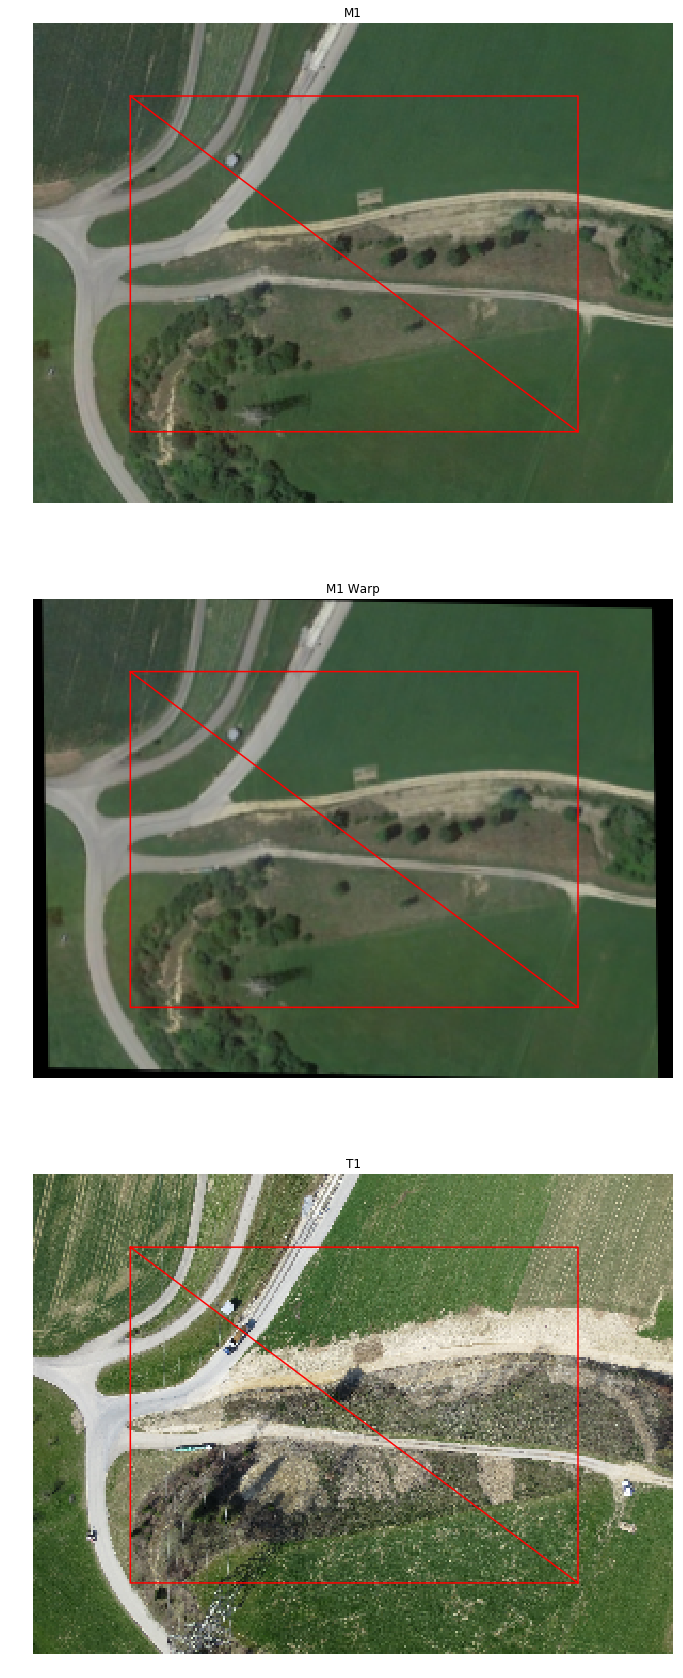

finished iteration: 1
extracting map templates...
... 1/1 ...
extracting map templates...
... 1/1 ...
Loading pretrained network...done
finished at iteration  151
finished at iteration  151


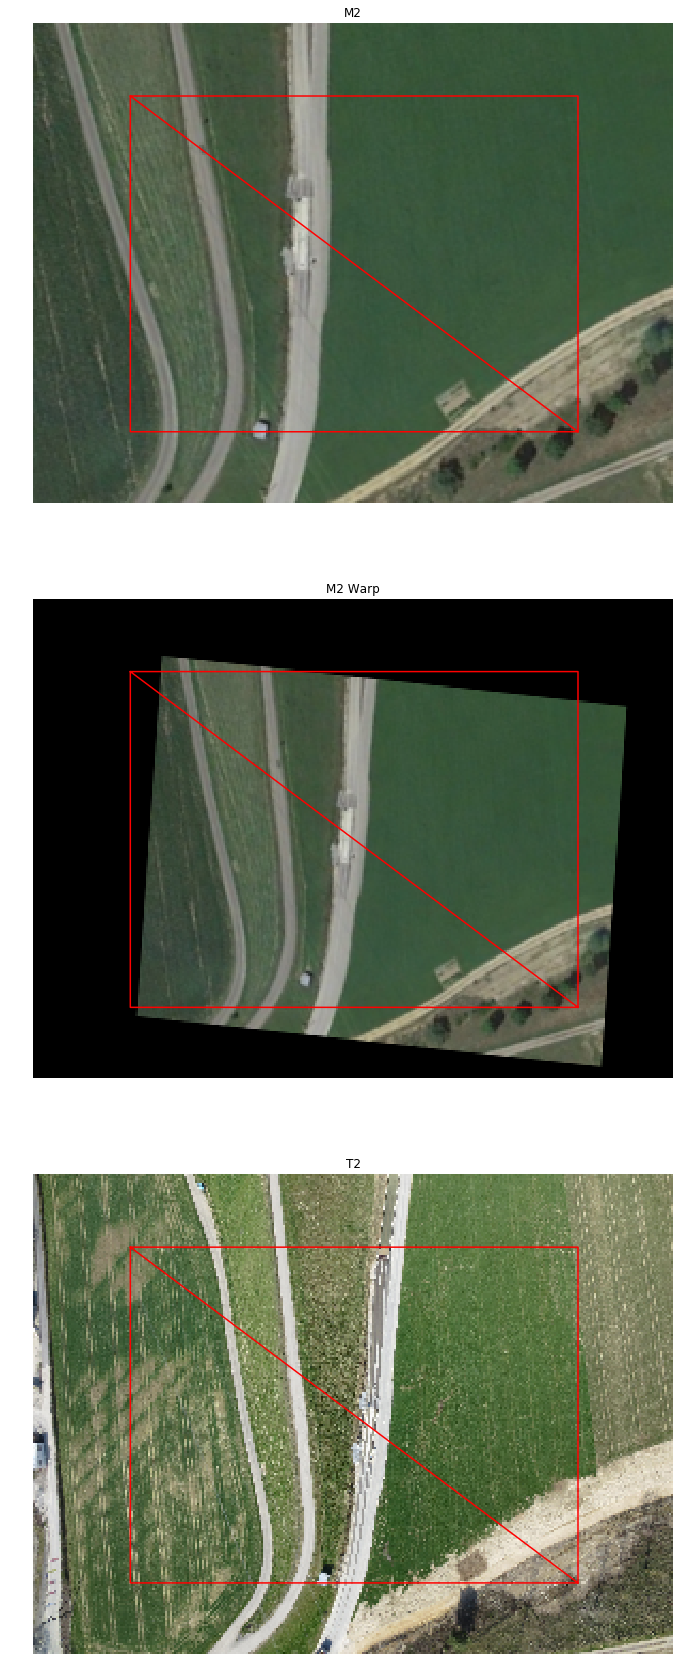

finished iteration: 2
extracting map templates...
... 1/1 ...
extracting map templates...
... 1/1 ...
Loading pretrained network...done
finished at iteration  151
finished at iteration  151


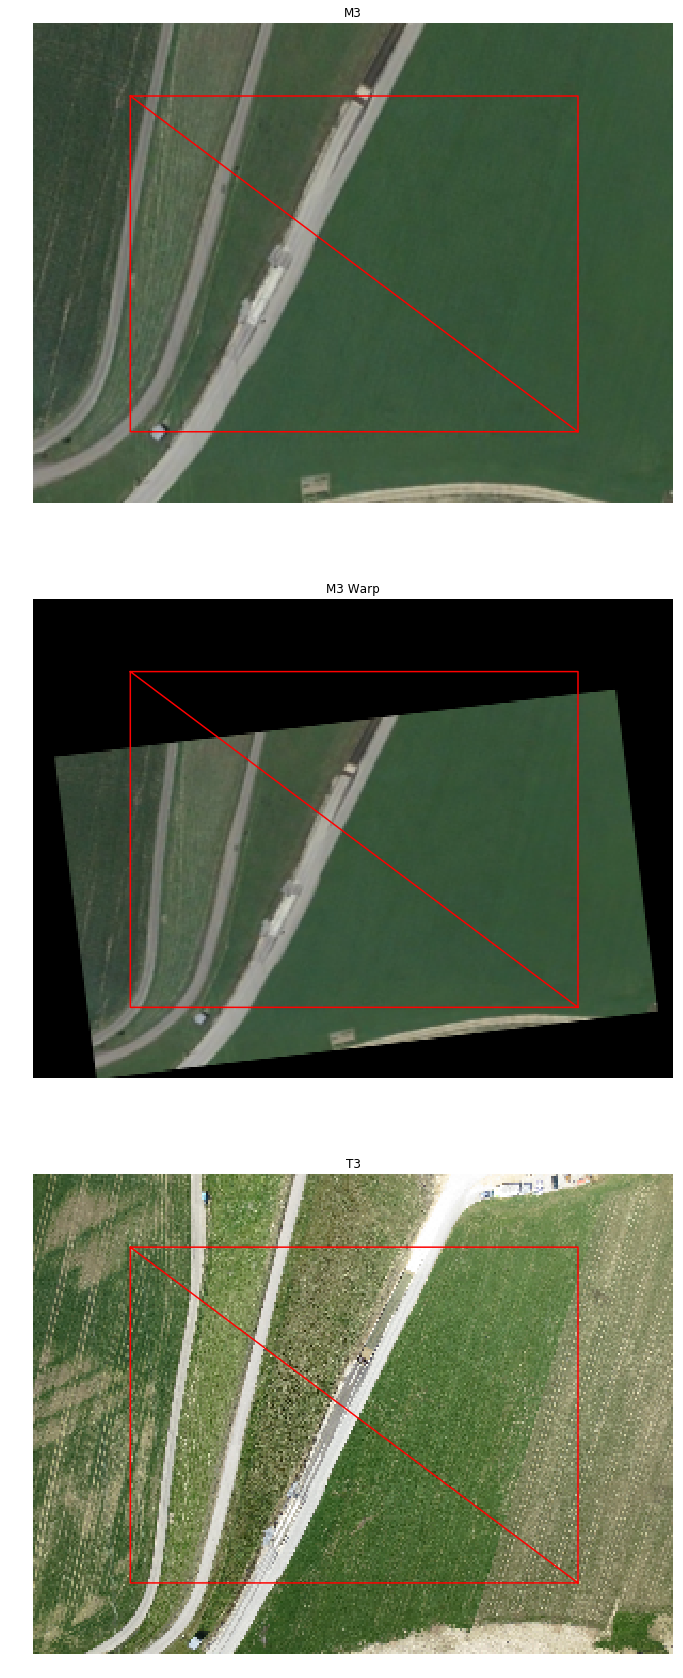

finished iteration: 3
extracting map templates...
... 1/1 ...
extracting map templates...
... 1/1 ...
Loading pretrained network...done
finished at iteration  151
finished at iteration  150


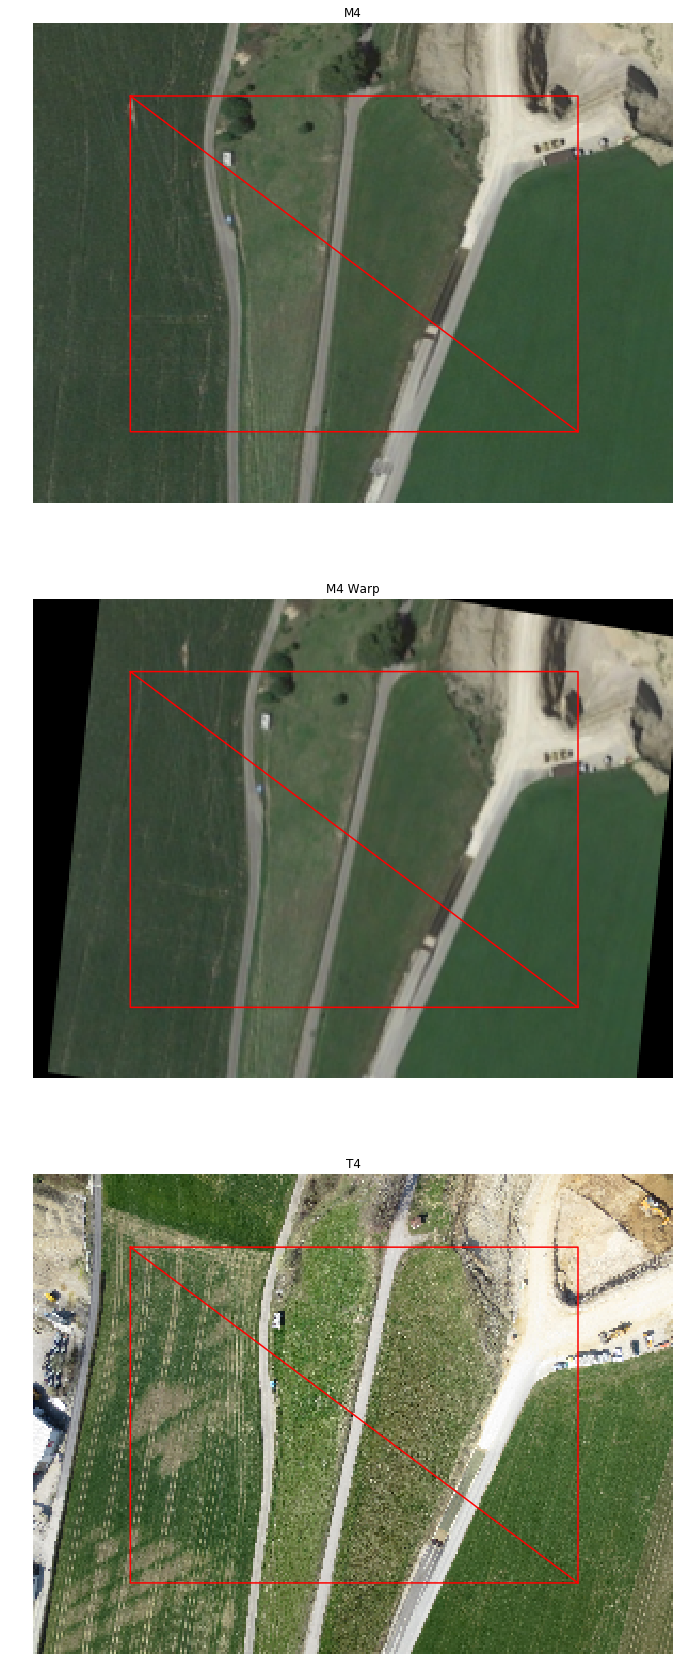

finished iteration: 4
extracting map templates...
... 1/1 ...
extracting map templates...
... 1/1 ...
Loading pretrained network...done
finished at iteration  151
finished at iteration  151


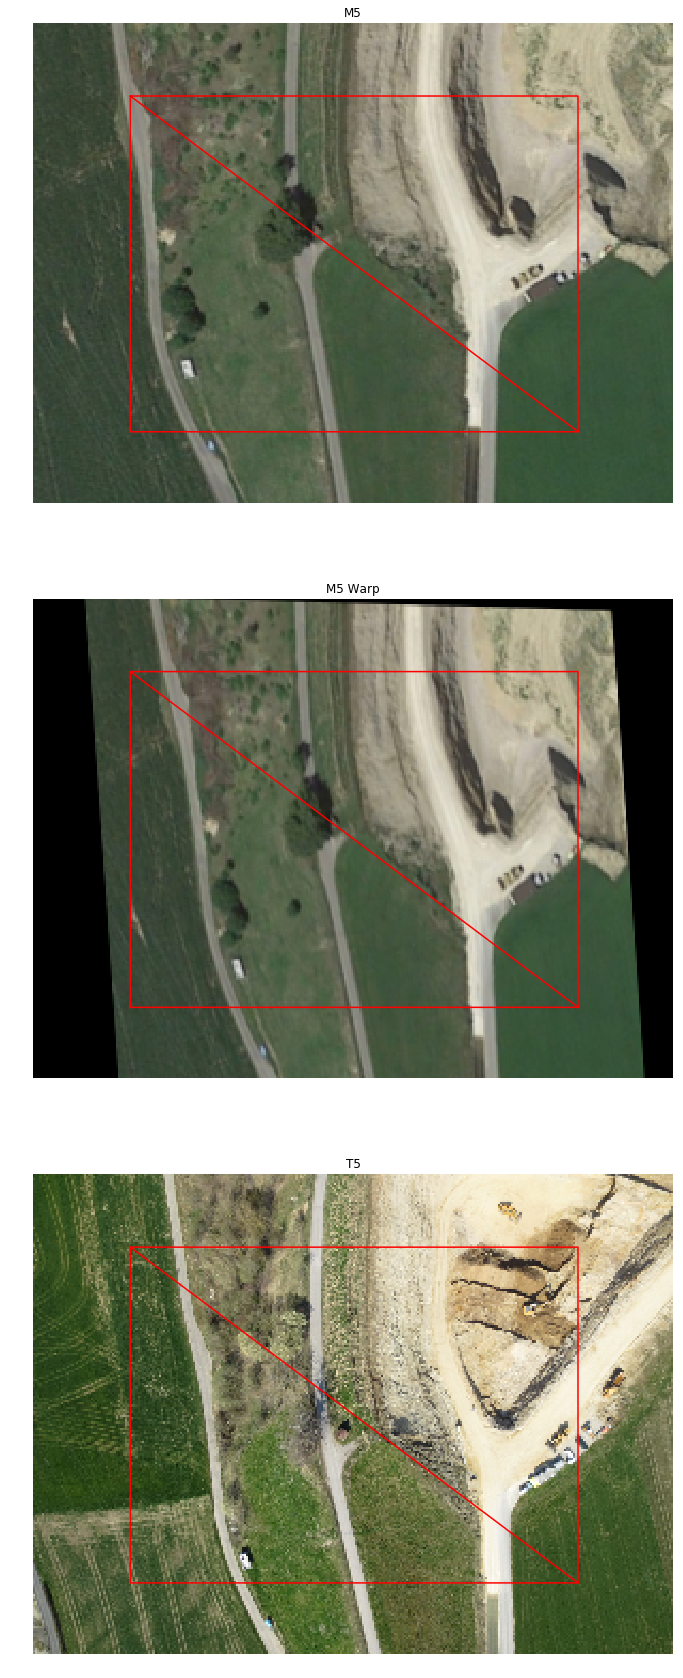

finished iteration: 5
extracting map templates...
... 1/1 ...
extracting map templates...
... 1/1 ...
Loading pretrained network...done
finished at iteration  151
finished at iteration  151


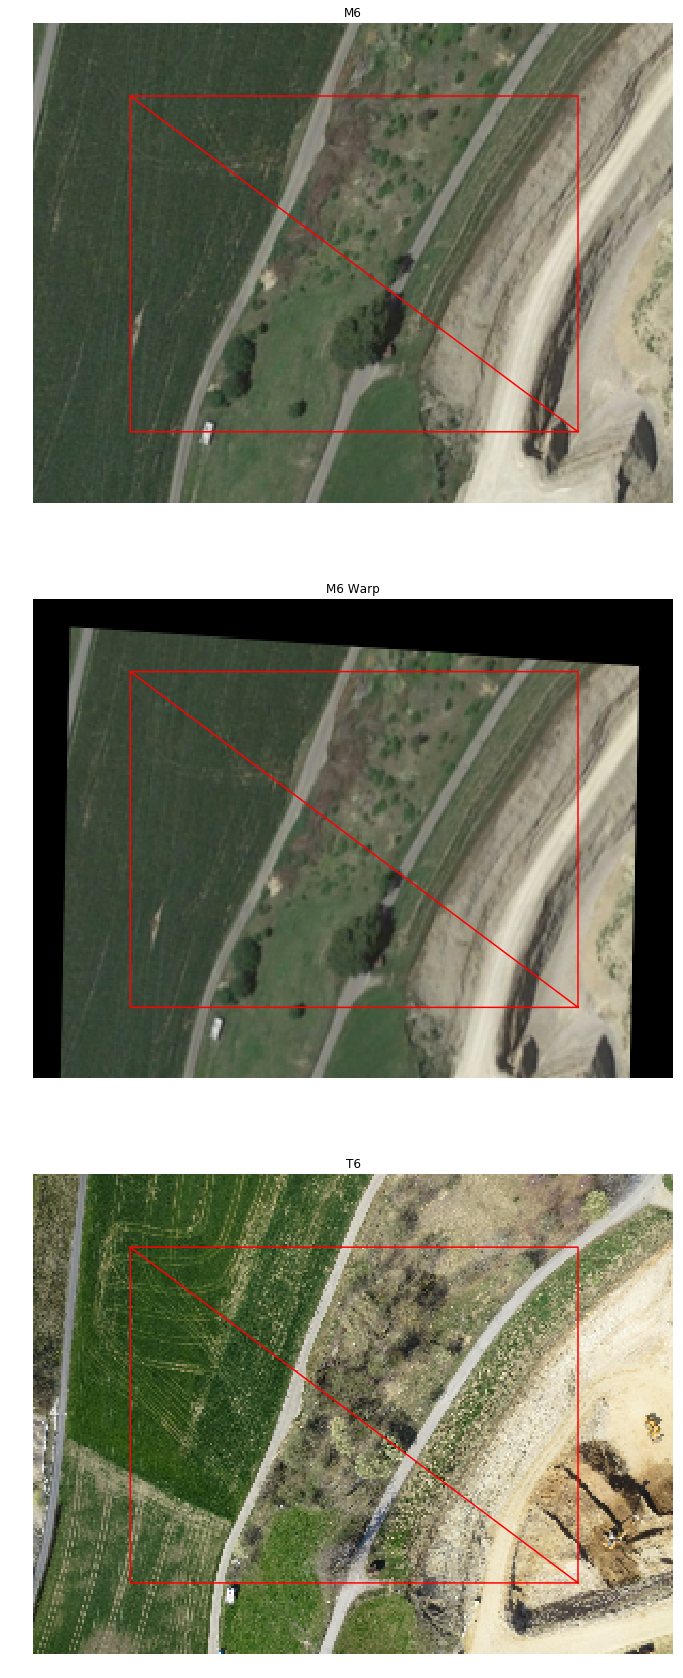

finished iteration: 6
extracting map templates...
... 1/1 ...
extracting map templates...
... 1/1 ...
Loading pretrained network...done
finished at iteration  151
finished at iteration  151


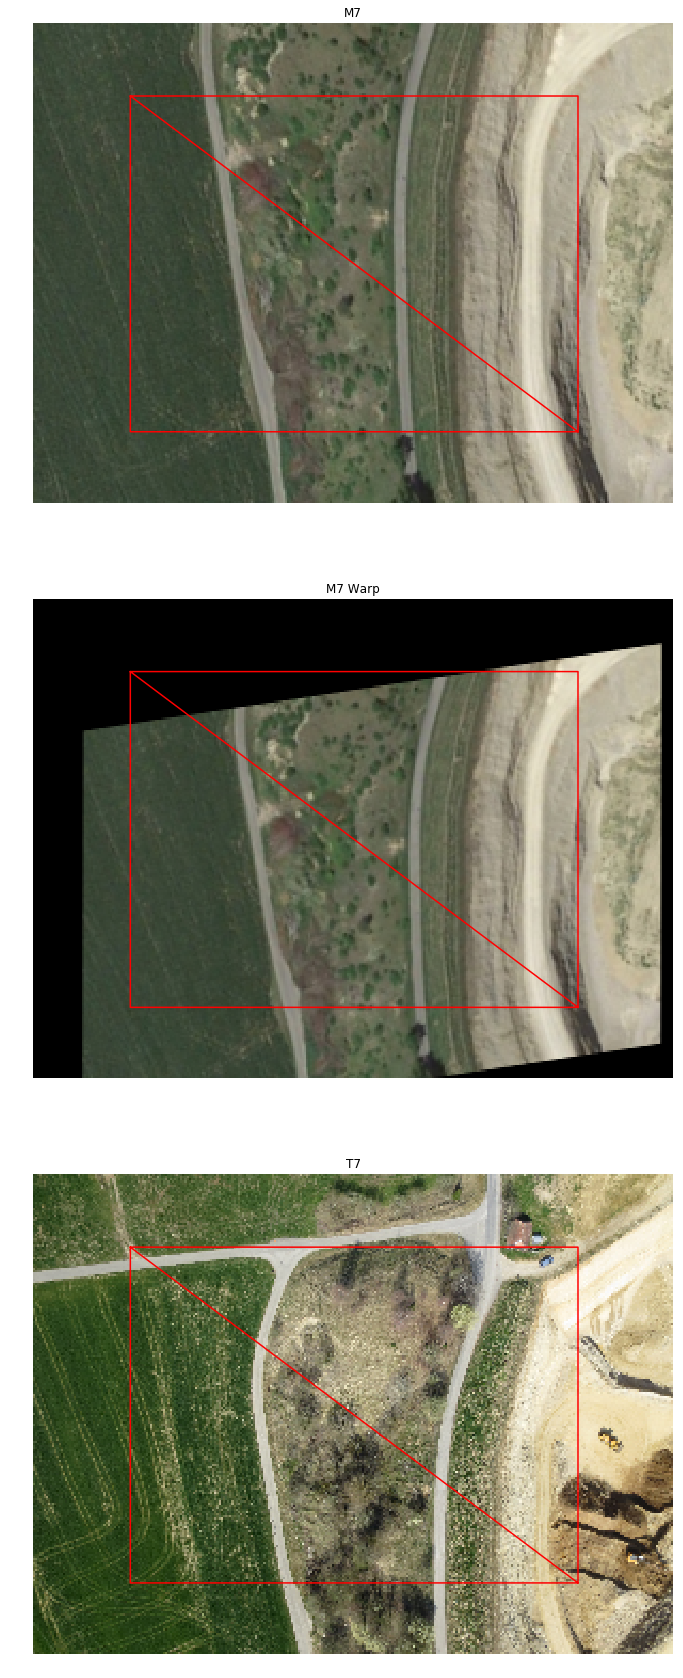

finished iteration: 7
extracting map templates...
... 1/1 ...
extracting map templates...
... 1/1 ...
Loading pretrained network...done
finished at iteration  151
finished at iteration  151


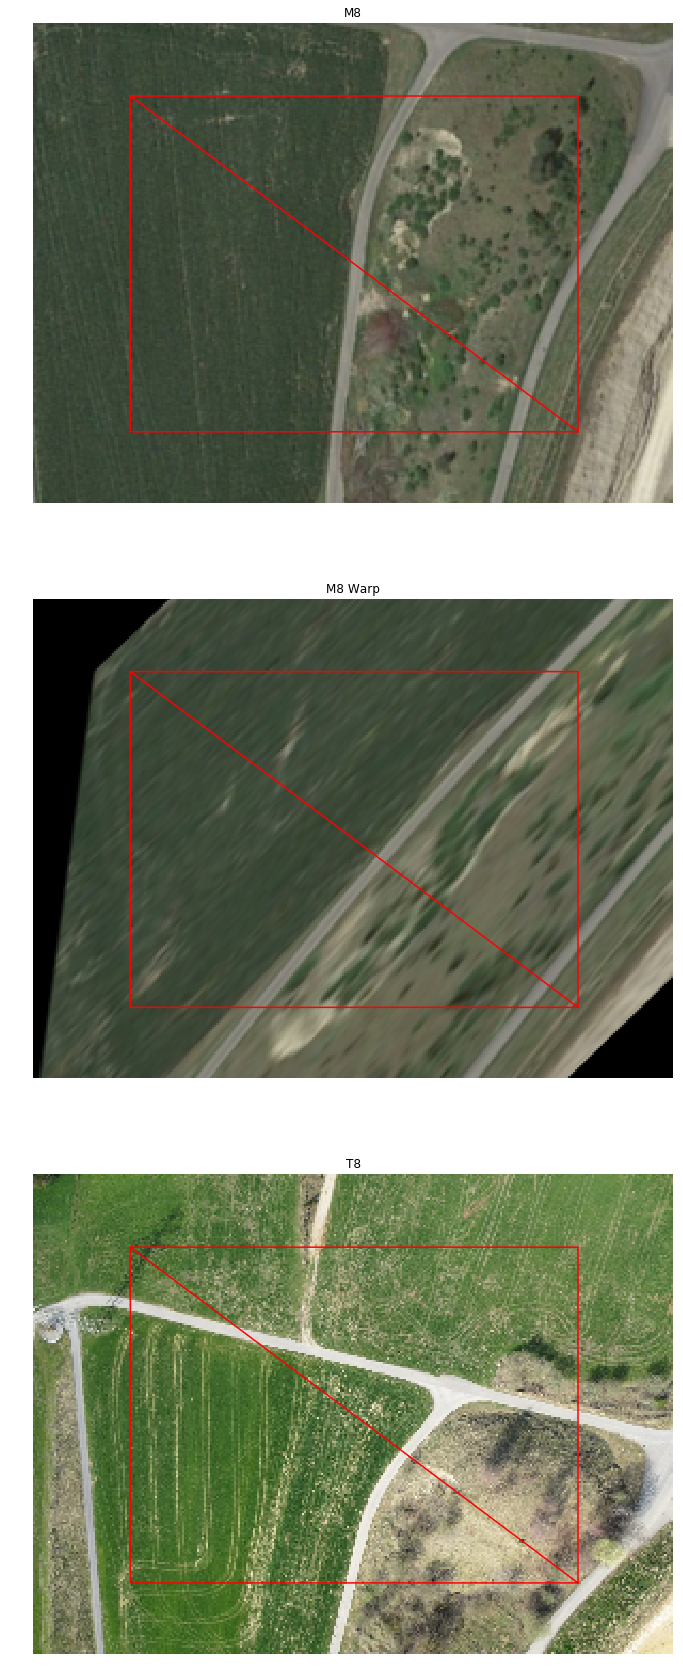

finished iteration: 8
extracting map templates...
... 1/1 ...
extracting map templates...
... 1/1 ...
Loading pretrained network...done
finished at iteration  151
finished at iteration  151


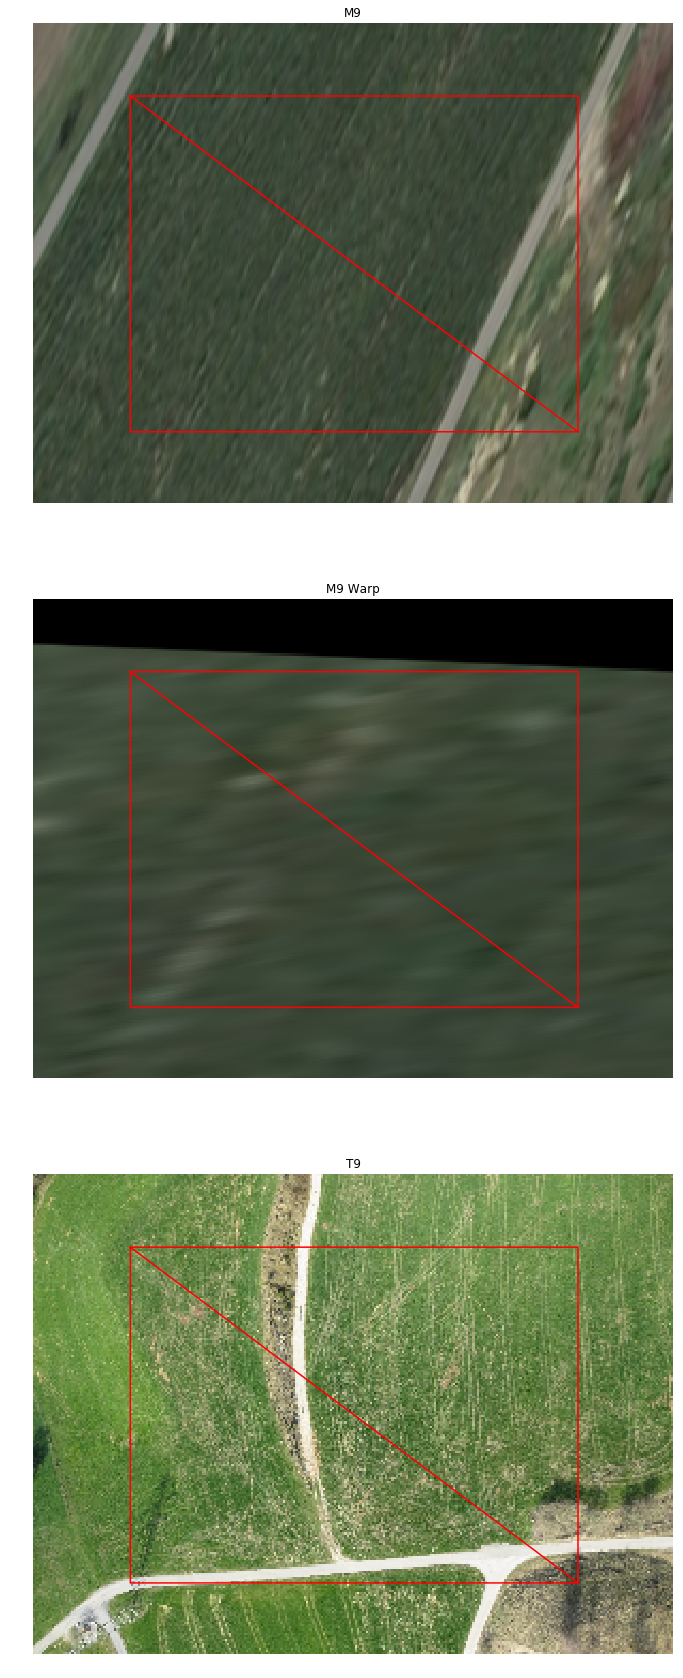

finished iteration: 9
extracting map templates...
... 1/1 ...
extracting map templates...
... 1/1 ...
Loading pretrained network...done
finished at iteration  151
finished at iteration  151


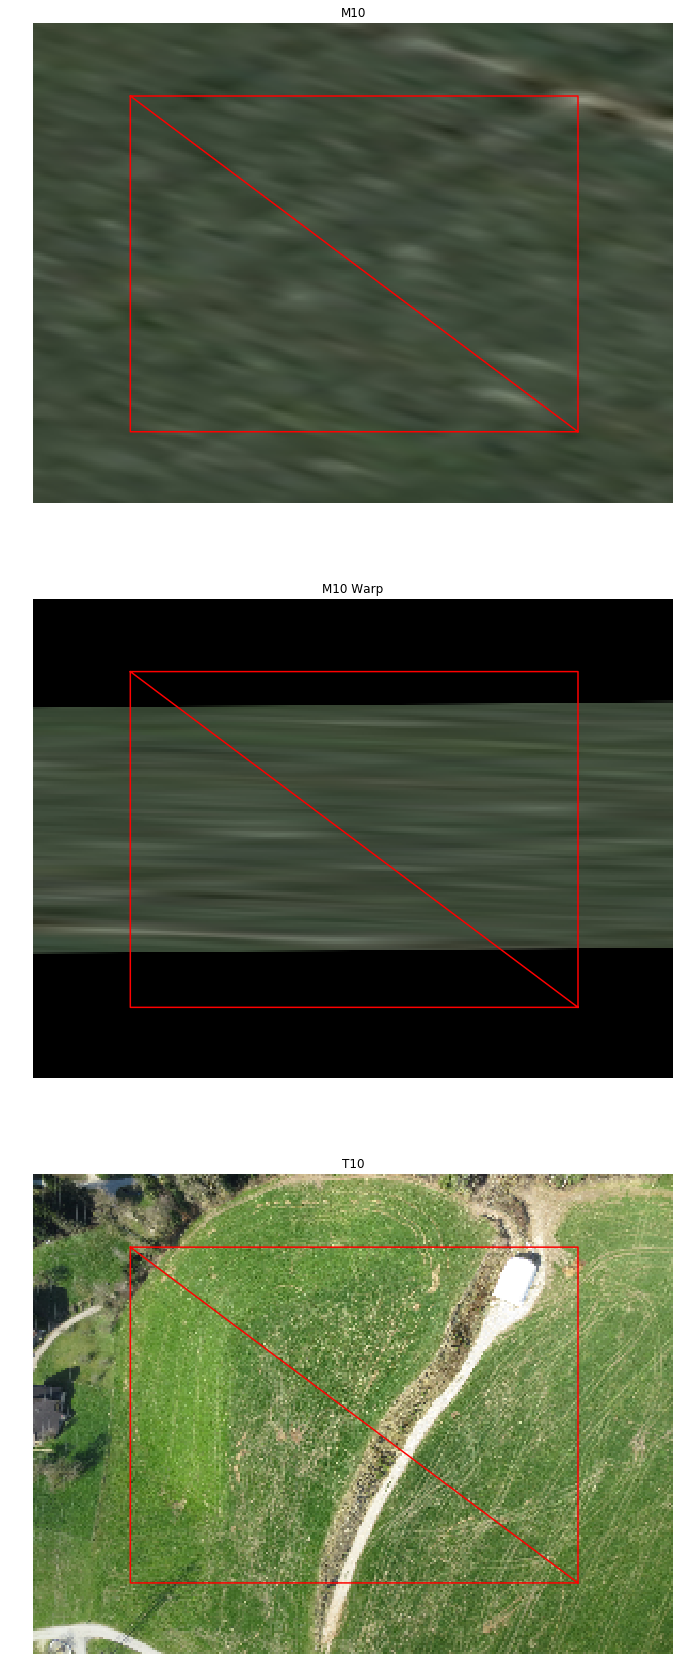

finished iteration: 10
extracting map templates...
... 1/1 ...
extracting map templates...
... 1/1 ...
Loading pretrained network...done
finished at iteration  151
finished at iteration  151


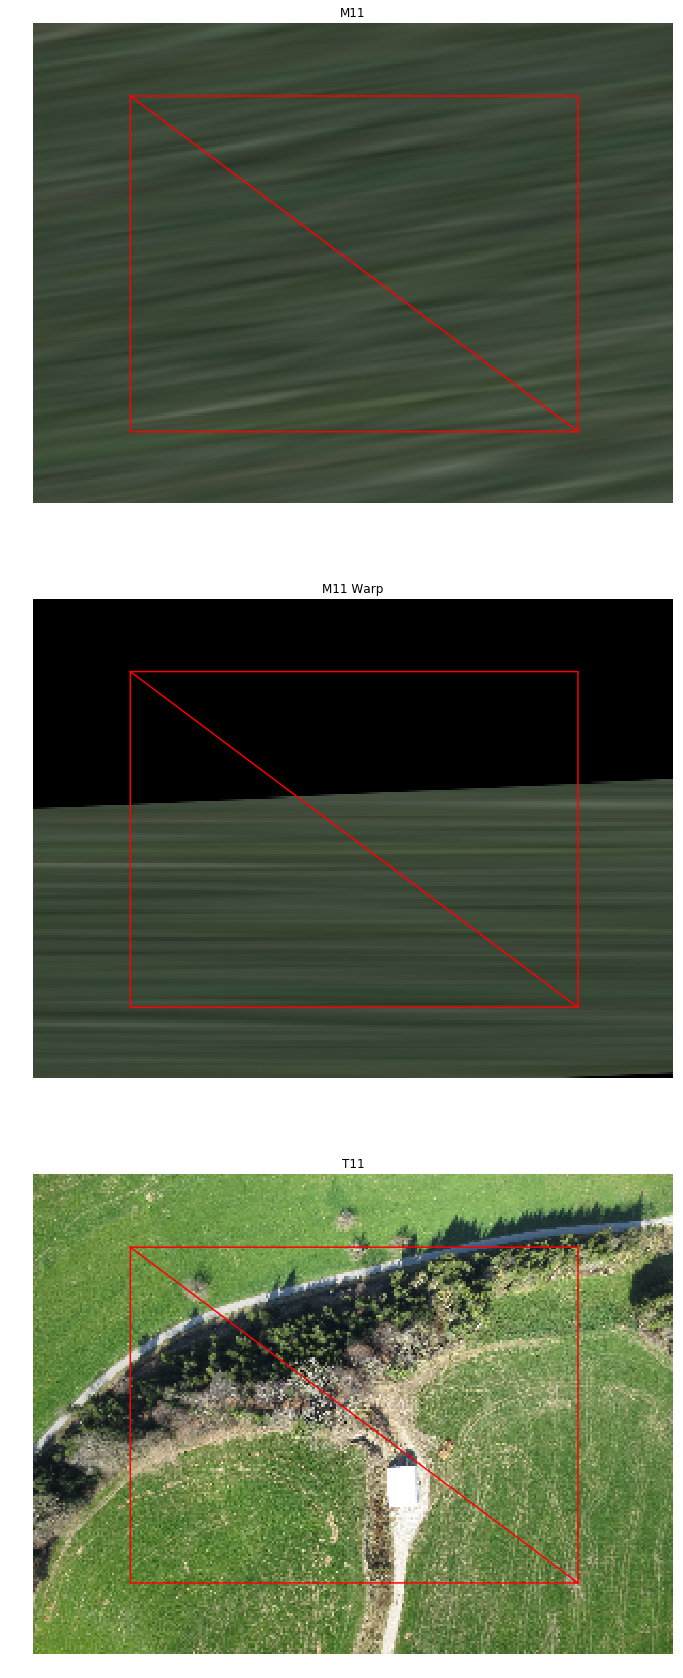

finished iteration: 11


In [29]:
#run_village()
run_country()